# **Intro M1**
In this notebook I set up semi-supervised VAE to predict cell type proportions from bulk data.
This is the original model structure (M1)
This is almost identical to "[DIVA: DOMAIN INVARIANT VARIATIONAL AUTOENCODERS](https://arxiv.org/pdf/1905.10427.pdf)".
To breifly describe the model, we have 3 independent encoders that encode for different sources of variation: cell-type proportion, sample-id, and everything else (slack).
To enforce this disentanglement, there are classification losses on the cell-type and smaple_id embeddings.
The embeddings are then concatenated together and used as input to a joint decoder.
When used in the semi-supervised mode, the classification loss is calculated by comparing the classifier output to the latent digit representation.
The model is depicted below.



The experimental set-up is as follows:
All data is from pbmc6k dataset.
Cells are sampled to generate 10 pesudobulks.
There are perturbed samples --> this means that for some samples we have mono14 cells instead of mono16 cells. 
This is like a perturbation that would cause one cell type to change.
We use 2 samples as the labeled data (meaning each sample has a ground truth) and 8 samples with unlabeled data (ground truth proportions are not used in training.)




This code was based off of DIVA's codebase: https://github.com/AMLab-Amsterdam/DIVA

Semi-supervised training method was take from here:
And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/

Another codebase referenced: https://github.com/saemundsson/semisupervised_vae



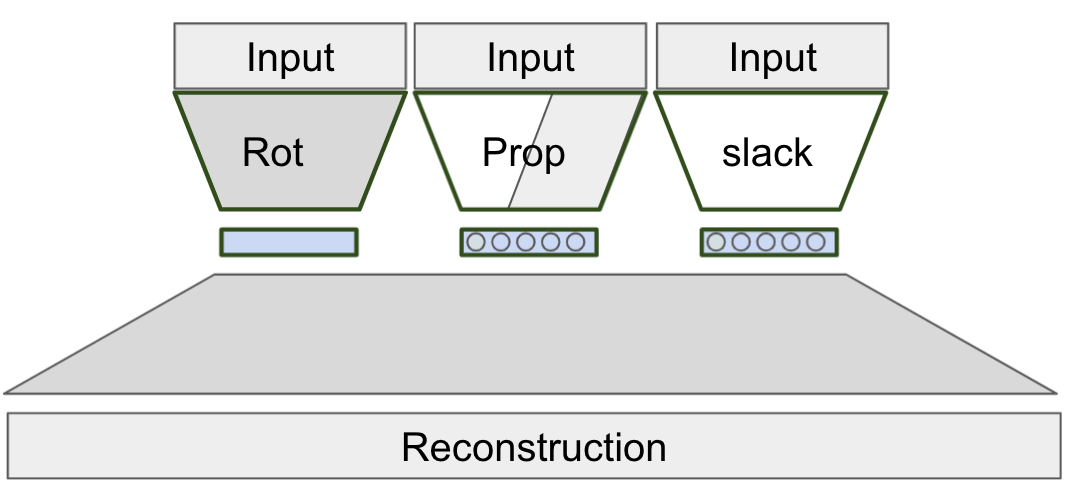

# **Imports**

In [58]:
# general imports
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from keras.layers.merge import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error, KLDivergence
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr, ttest_ind, wilcoxon
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

from tqdm import tnrange, tqdm_notebook
import ipywidgets

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# import the SC_preprocessing code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess
from method_comparison import validation_plotting as vp


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [59]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)
reload(vp)

<module 'method_comparison.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/exploratory_experiments/../method_comparison/validation_plotting.py'>

In [60]:
## parameters
aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_kang_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_kang/"
cibersort_genes_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_phenoclasses.CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_refsample.bm.K999.txt"

# cibersort results
cibersort_file_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/CIBERSORTx_Job18_Results.csv"

# bp results
bp_res_path = f"{os.getcwd()}/../results/single_cell_data/bp_kang/"

# DiffExp results
de_res_path = f"{os.getcwd()}/../data/single_cell_data/kang_rybakov/kang_DE_paper.tsv"

num_genes = 7000

exp_id = "none-kang"

# Set-up experimental variables

In [61]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 10

# number of patients/domains/samples expected
idx_range = range(0, 16)
n_tot_samples = 8 # 8 patients, 2 samples each

# number of drugs (one-hot encoded)
n_drugs = 2

# experiment id
lab_file_name = exp_id


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [62]:

##################################################
#####. Design the experiment
##################################################

# read in the labeled data
X_full, Y_full, gene_df, meta_df = sc_preprocess.read_all_kang_pseudobulk_files(aug_data_path, exp_id)
X_full.columns = gene_df

X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]

# only get genes that are available in both testing and training
common_genes_file = os.path.join(aug_data_path, "kang_genes.pkl")
gene_out_path = Path(common_genes_file)
common_genes = pickle.load(open( gene_out_path, "rb" ))

# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(common_genes, cibersort_genes)

X_train_df = X_train_df[common_genes]

gene_df = gene_df.loc[gene_df.isin(common_genes)]


# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -num_genes)[-num_genes:]
gene_df = gene_df.iloc[idx_top]


In [63]:
X_train_df

gene_ids LINC00115 NOC2L KLHL17 PLEKHN1 HES4  ISG15 AGRN C1orf159 TNFRSF18  \
0              165   510      8      51  875  15392    0       52      405   
0              142   932      2     596  216   9662    0       44      566   
0              506  1584      0    1131   68  13818    0       86      537   
0              255  1371      0     603  402  11352    0      123     1006   
0               84  1291      4     311  486   8505    0       29      781   
..             ...   ...    ...     ...  ...    ...  ...      ...      ...   
0              263   425      0      12   37   2110    0        0      199   
0              270   486      0      28   13   2488    0        0       83   
0              199   445      0       8   69   2354    0        0      167   
0              464   421      0      25   36   2757    0        0      107   
0              484   531      0      32   79   2671    0        0      152   

gene_ids TNFRSF4  ... CPT1B AF127936.5 AJ006998.2 CHODL AP000476.1 LINC00158  \
0           1289  ...     0          0          0     0          0         0   
0           5343  ...     0          0          0     0          0         0   
0          13384  ...     0          0          0     0          0         0   
0           8208  ...     0          0          0     0          0         0   
0           3081  ...     0          0          0     0          0         0   
..           ...  ...   ...        ...        ...   ...        ...       ...   
0            592  ...     0          0          0     0          0         0   
0            604  ...     0          0          0     0          0         0   
0            745  ...     0          0          0     0          0         0   
0           1003  ...     0          0          0     0          0         0   
0            602  ...     0          0          0     0          0         0   

gene_ids AF131217.1 AP001437.1 TMPRSS3 LRRC3DN  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
..              ...        ...     ...     ...  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  

[2120 rows x 13452 columns]

In [64]:
X_train

array([[165, 510, 8, ..., 0, 0, 0],
       [142, 932, 2, ..., 0, 0, 0],
       [506, 1584, 0, ..., 0, 0, 0],
       ...,
       [199, 445, 0, ..., 0, 0, 0],
       [464, 421, 0, ..., 0, 0, 0],
       [484, 531, 0, ..., 0, 0, 0]], dtype=object)

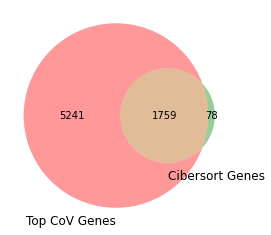

In [65]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [66]:
union_genes = np.union1d(gene_df, cibersort_genes)


In [67]:
def pearsonr_2D(x, y):
    """computes pearson correlation coefficient
       where x is a 1D and y a 2D array"""

    upper = np.sum((x - np.mean(x)) * (y - np.mean(y, axis=1)[:,None]), axis=1)
    lower = np.sqrt(np.sum(np.power(x - np.mean(x), 2)) * np.sum(np.power(y - np.mean(y, axis=1)[:,None], 2), axis=1))
    
    rho = upper / lower
    
    return rho

In [68]:
X_full = X_full.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()



/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 15320 samples in 0.059s...
[t-SNE] Computed neighbors for 15320 samples in 18.088s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15320
[t-SNE] Computed conditional probabilities for sample 2000 / 15320
[t-SNE] Computed conditional probabilities for sample 3000 / 15320
[t-SNE] Computed conditional probabilities for sample 4000 / 15320
[t-SNE] Computed conditional probabilities for sample 5000 / 15320
[t-SNE] Computed conditional probabilities for sample 6000 / 15320
[t-SNE] Computed conditional probabilities for sample 7000 / 15320
[t-SNE] Computed conditional probabilities for sample 8000 / 15320
[t-SNE] Computed conditional probabilities for sample 9000 / 15320
[t-SNE] Computed conditional probabilities for sample 10000 / 15320
[t-SNE] Computed conditional probabilities for sample 11000 / 15320
[t-SNE] Computed conditional probabilities for sample 12000 / 15320
[t-SNE] Computed conditional probabilities for sa

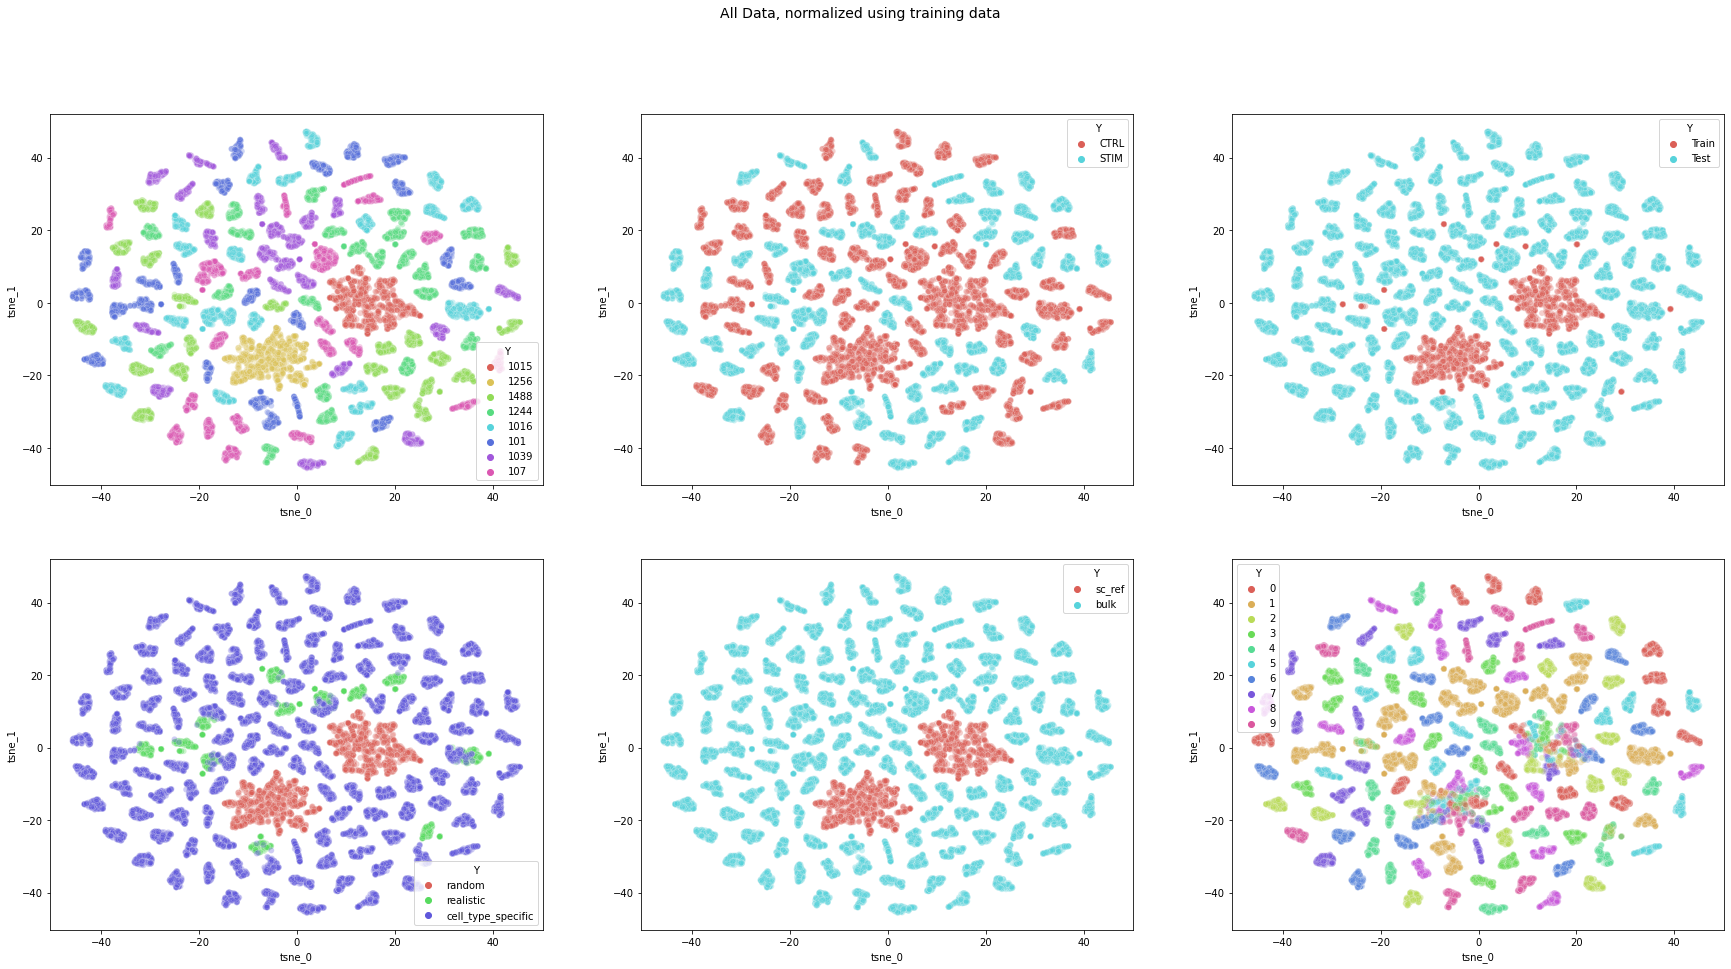

In [69]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()


(13320, 2)
(13320, 2)


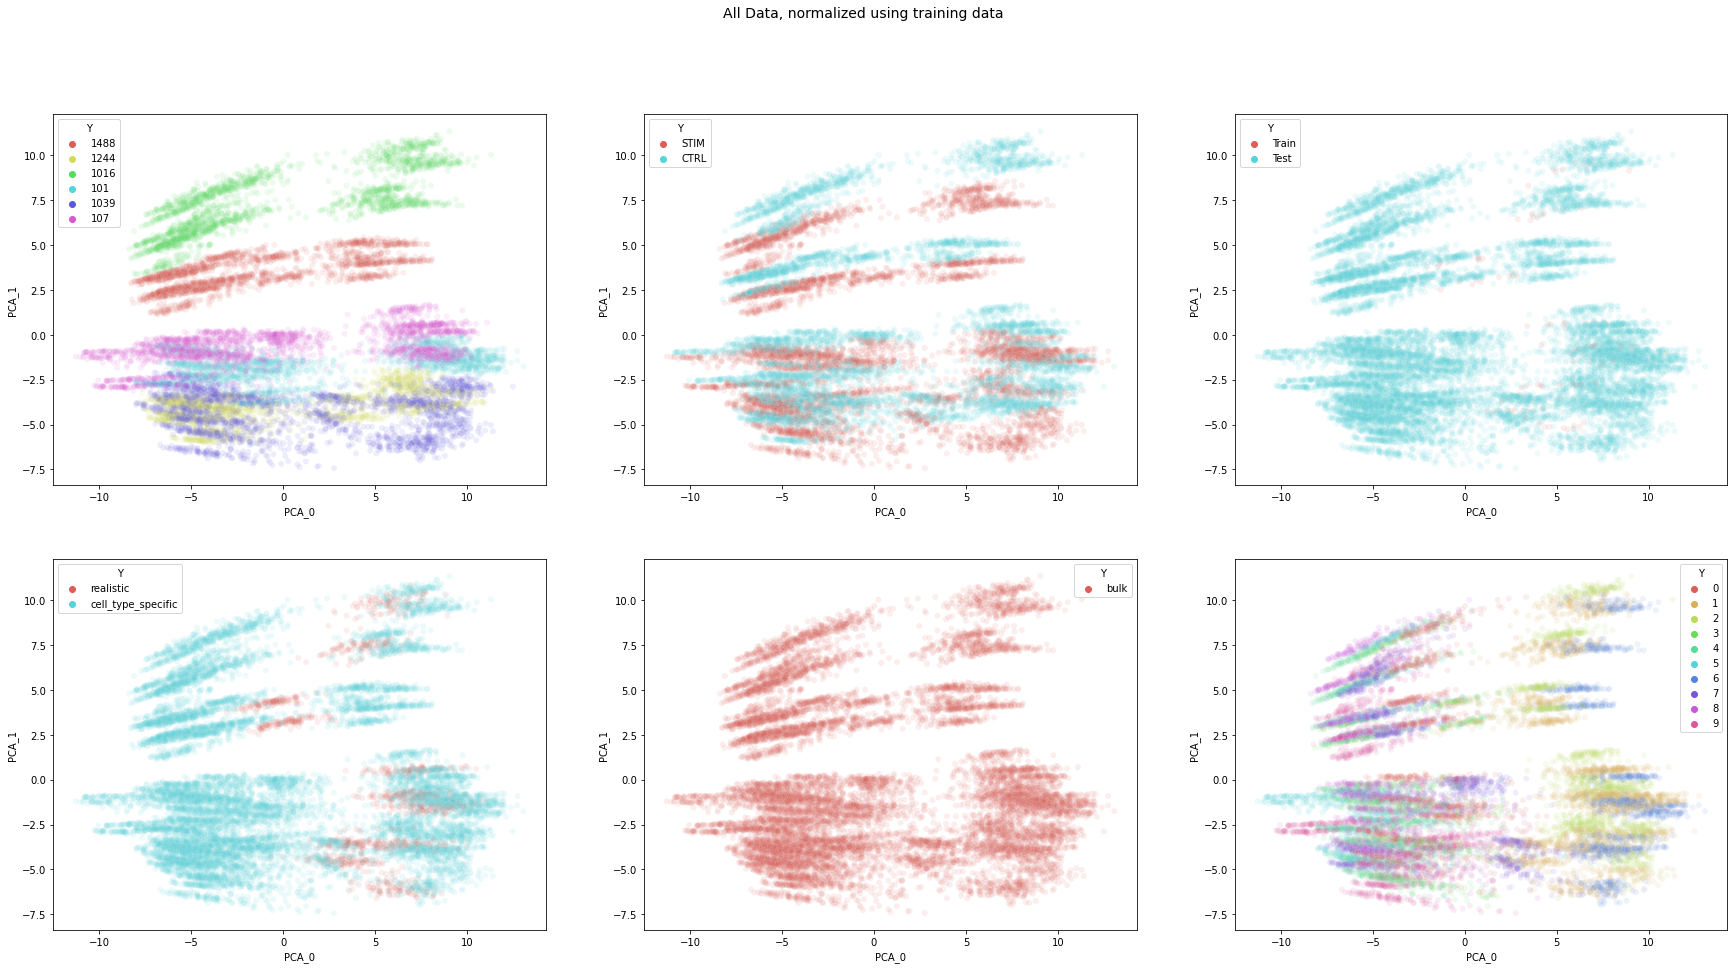

In [70]:
## plot samples
idx_interest = np.where(meta_df.samp_type == "bulk")[0]

plot_df = vp.get_pca_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"")
vp.plot_pca(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"")
vp.plot_pca(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"")
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"")
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()


(2220, 2)
(2220, 2)


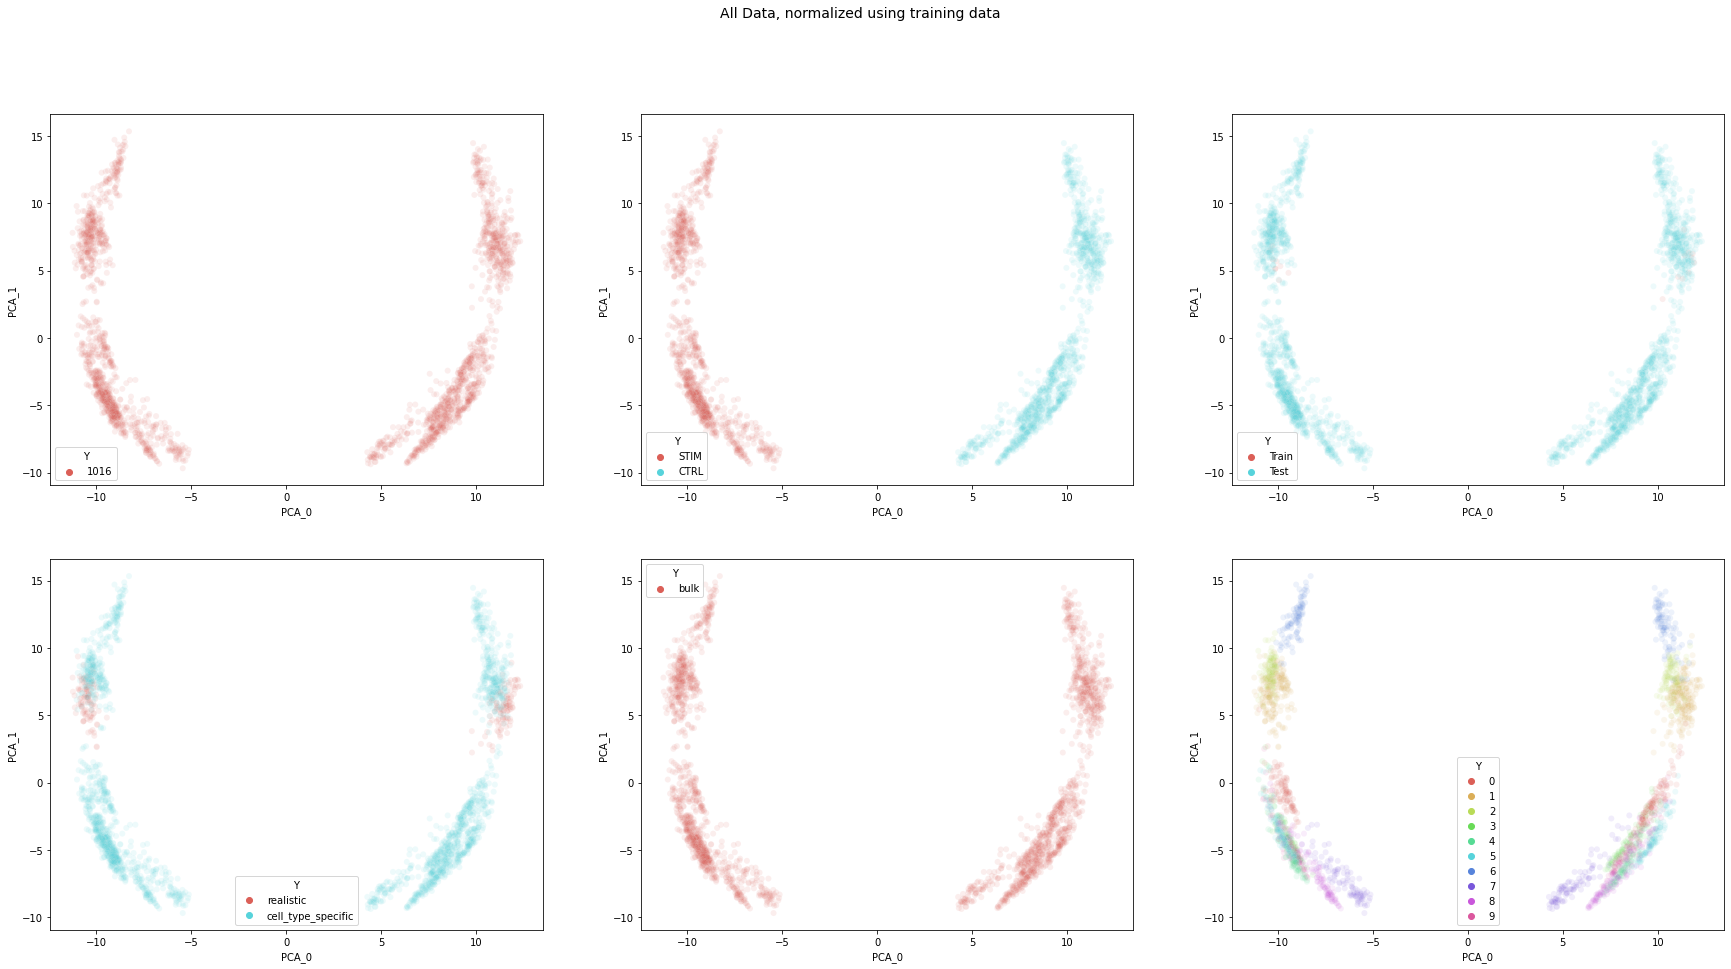

In [71]:
idx_interest = np.logical_and(meta_df.samp_type == "bulk", meta_df.sample_id == "1016")
idx_interest = np.where(idx_interest)[0]


plot_df = vp.get_pca_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"")
vp.plot_pca(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"")
vp.plot_pca(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"")
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"")
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()



In [72]:
np.random.lognormal(0, 1, 10) 

array([1.44781758, 1.73266227, 2.18322673, 0.96103538, 2.44733452,
       0.72402618, 1.66498699, 0.8005263 , 0.24926404, 1.23511246])

# **M2 Model Definition**

## Hyperparameters

In [73]:

##################################################
#####. Hyperparameters
##################################################

batch_size = 500
n_epoch = 150 # 500 

alpha_rot = 1000000 #1000000
alpha_drug = 10000 #1000000
alpha_prop = 100 #100

beta_kl_slack = 0.1 # 10 ###
beta_kl_rot = 100 # 100 ###
beta_kl_drug = 100 # 100 ###


n_x = X_full.shape[1]
n_y = Y_full.shape[1]
n_label = n_tot_samples  # 8 donors 
n_drugs = n_drugs  # number of drugs one-hot encoded
n_label_z = 64  # 64 dimensional representation of rotation


# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
n_z = Y_full.shape[1] # latent space size, one latent dimension PER cell type
encoder_dim = 512 # dim of encoder hidden layer 512 
decoder_dim = 512 # dim of encoder hidden layer 512 
decoder_out_dim = n_x # dim of decoder output layer

# labeled classifier
class_dim1 = 512 # 512 
class_dim2 = 256 # 256 


activ = 'relu'
optim = Adam(learning_rate=0.0005) #0.001
print(f"length of X {n_x} and length of y {n_y} n_label {n_label} and n_drugs {n_drugs}")



length of X 7078 and length of y 10 n_label 8 and n_drugs 2


## Encoder + Y classifier

In [74]:
# declare the Keras tensor we will use as input to the encoder
X = Input(shape=(n_x,))
Y = Input(shape=(n_y,))
label = Input(shape=(n_label,))
props = Input(shape=(n_y,))
z_in = Input(shape=(n_y+n_label_z+n_label_z+n_label_z,))
cls_in = Input(shape=(n_label_z,))

inputs = X

# set up encoder network
# this is an encoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
encoder_s = Dense(encoder_dim, activation=activ, name="encoder_slack")(inputs)
encoder_r = Dense(encoder_dim, activation=activ, name="encoder_rot")(inputs)
encoder_d = Dense(encoder_dim, activation=activ, name="encoder_drug")(inputs)

# now from the hidden layer, you get the mu and sigma for 
# the latent space

mu_slack = Dense(n_label_z, activation='linear', name = "mu_slack")(encoder_s)
l_sigma_slack = Dense(n_label_z, activation='linear', name = "sigma_slack")(encoder_s)

mu_rot = Dense(n_label_z, activation='linear', name = "mu_rot")(encoder_r)
l_sigma_rot = Dense(n_label_z, activation='linear', name = "sigma_rot")(encoder_r)


mu_drug = Dense(n_label_z, activation='linear', name = "mu_drug")(encoder_d)
l_sigma_drug = Dense(n_label_z, activation='linear', name = "sigma_drug")(encoder_d)



# set up labeled classifier
#defining the architecture of the classifier

class_hidden1 = Dense(class_dim1, activation=activ, name = "cls_h1")
class_hidden2 = Dense(class_dim2, activation=activ, name="cls_h2")
class_out = Dense(n_y, activation='softmax', name="cls_out")

#x_concat_lab = tf.keras.layers.concatenate([inputs, label])
#classifier_h1 = class_hidden1(tf.keras.layers.Concatenate()([inputs, label]))
classifier_h1 = class_hidden1(inputs)
classifier_h2 = class_hidden2(classifier_h1)
Y_cls = class_out(classifier_h2)



## Latent Space

In [75]:
# now we need the sampler from mu and sigma
def sample_z(args):
    mu, l_sigma, n_z = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z_slack = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_slack")([mu_slack, l_sigma_slack, n_label_z])
z_rot = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_rot")([mu_rot, l_sigma_rot, n_label_z])
z_drug = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_drug")([mu_drug, l_sigma_drug, n_label_z])

z_concat_lab = concat([z_slack, Y, z_rot, z_drug])
z_concat_unlab = concat([z_slack, Y_cls, z_rot, z_drug])

## Decoder + Classifiers

In [76]:
def null_f(args):
    return args

###### DECODER
# set up decoder network
# this is a decoder with 512 hidden layer
decoder_hidden = Dense(decoder_dim, activation=activ, name = "decoder_h1")

# final reconstruction
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name = "decoder_out")

d_in = Input(shape=(n_label_z+n_y+n_label_z+n_label_z,))
d_h1 = decoder_hidden(d_in)
d_out = decoder_out(d_h1)

# set up the decoder part that links to the encoder
# labeled decoder
h_lab = decoder_hidden(z_concat_lab)
outputs_lab = decoder_out(h_lab)

# unlabeled decoder
h_unlab = decoder_hidden(z_concat_unlab)
outputs_unlab = decoder_out(h_unlab)


###### Rotations classifier
# this is the rotation we try to estimate
rot_h1 = ReLU(name = "rot_h1")
rot_h2 = Dense(n_label, activation='linear', name = "rot_h2")
rot_softmax = Softmax(name = "mu_rot_pred")
decoder_sigma_r = Lambda(null_f, name = "l_sigma_rot_pred")


rot_1_out = rot_h1(z_rot)
rot_2_out = rot_h2(rot_1_out)
rotation_outputs = rot_softmax(rot_2_out)
sigma_outputs_r = decoder_sigma_r(l_sigma_rot)



###### Drug classifier
# this is the drug we try to estimate
drug_h1 = ReLU(name = "drug_h1")
drug_h2 = Dense(n_drugs, activation='linear', name = "drug_h2")
drug_softmax = Softmax(name = "mu_drug_pred")
decoder_sigma_d = Lambda(null_f, name = "l_sigma_drug_pred")


drug_1_out = drug_h1(z_drug)
drug_2_out = drug_h2(drug_1_out)
drug_outputs = drug_softmax(drug_2_out)
sigma_outputs_d = decoder_sigma_d(l_sigma_drug)








## Loss

In [77]:

def vae_loss(y_true, y_pred):
    recon = K.sum(mean_squared_error(y_true, y_pred), axis=-1)
    kl_rot = beta_kl_rot * K.sum(K.exp(l_sigma_rot) + K.square(mu_rot) - 1. - l_sigma_rot, axis=-1)
    kl_drug = beta_kl_drug * K.sum(K.exp(l_sigma_drug) + K.square(mu_drug) - 1. - l_sigma_drug, axis=-1)
    kl_slack = beta_kl_slack * K.sum(K.exp(l_sigma_slack) + K.square(mu_slack) - 1. - l_sigma_slack, axis=-1)
    return recon + kl_rot +kl_drug+ kl_slack


def recon_loss(y_true, y_pred):
	return K.sum(mean_squared_error(y_true, y_pred), axis=-1)


def prop_loss(y_true, y_pred):
  return K.sum(mean_absolute_error(y_true, y_pred), axis=-1) * alpha_prop

def drug_loss(y_true, y_pred):
  return K.sum(mean_absolute_error(y_true, y_pred), axis=-1) * alpha_drug


def class_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)*alpha_rot
    return recon



## Make the computational graph

In [78]:
classifier = Model(X, Y_cls)

known_prop_vae = Model([X, Y], [outputs_lab, Y_cls, rotation_outputs, drug_outputs])
unknown_prop_vae = Model(X, [outputs_unlab, rotation_outputs, drug_outputs])

known_prop_vae.compile(optimizer=optim, loss=[vae_loss, prop_loss, class_loss, drug_loss]) #, metrics = [KL_loss, recon_loss])
unknown_prop_vae.compile(optimizer=optim, loss=[vae_loss, class_loss, drug_loss]) #, metrics = [KL_loss, recon_loss])

encoder_unlab = Model(X, [z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug])

encoder_lab = Model([X, Y], [z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug])


decoder = Model(d_in, d_out)


print(known_prop_vae.summary())
print(unknown_prop_vae.summary())


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 7078)]       0                                            
__________________________________________________________________________________________________
encoder_slack (Dense)           (None, 512)          3624448     input_8[0][0]                    
__________________________________________________________________________________________________
encoder_rot (Dense)             (None, 512)          3624448     input_8[0][0]                    
__________________________________________________________________________________________________
encoder_drug (Dense)            (None, 512)          3624448     input_8[0][0]                    
____________________________________________________________________________________________

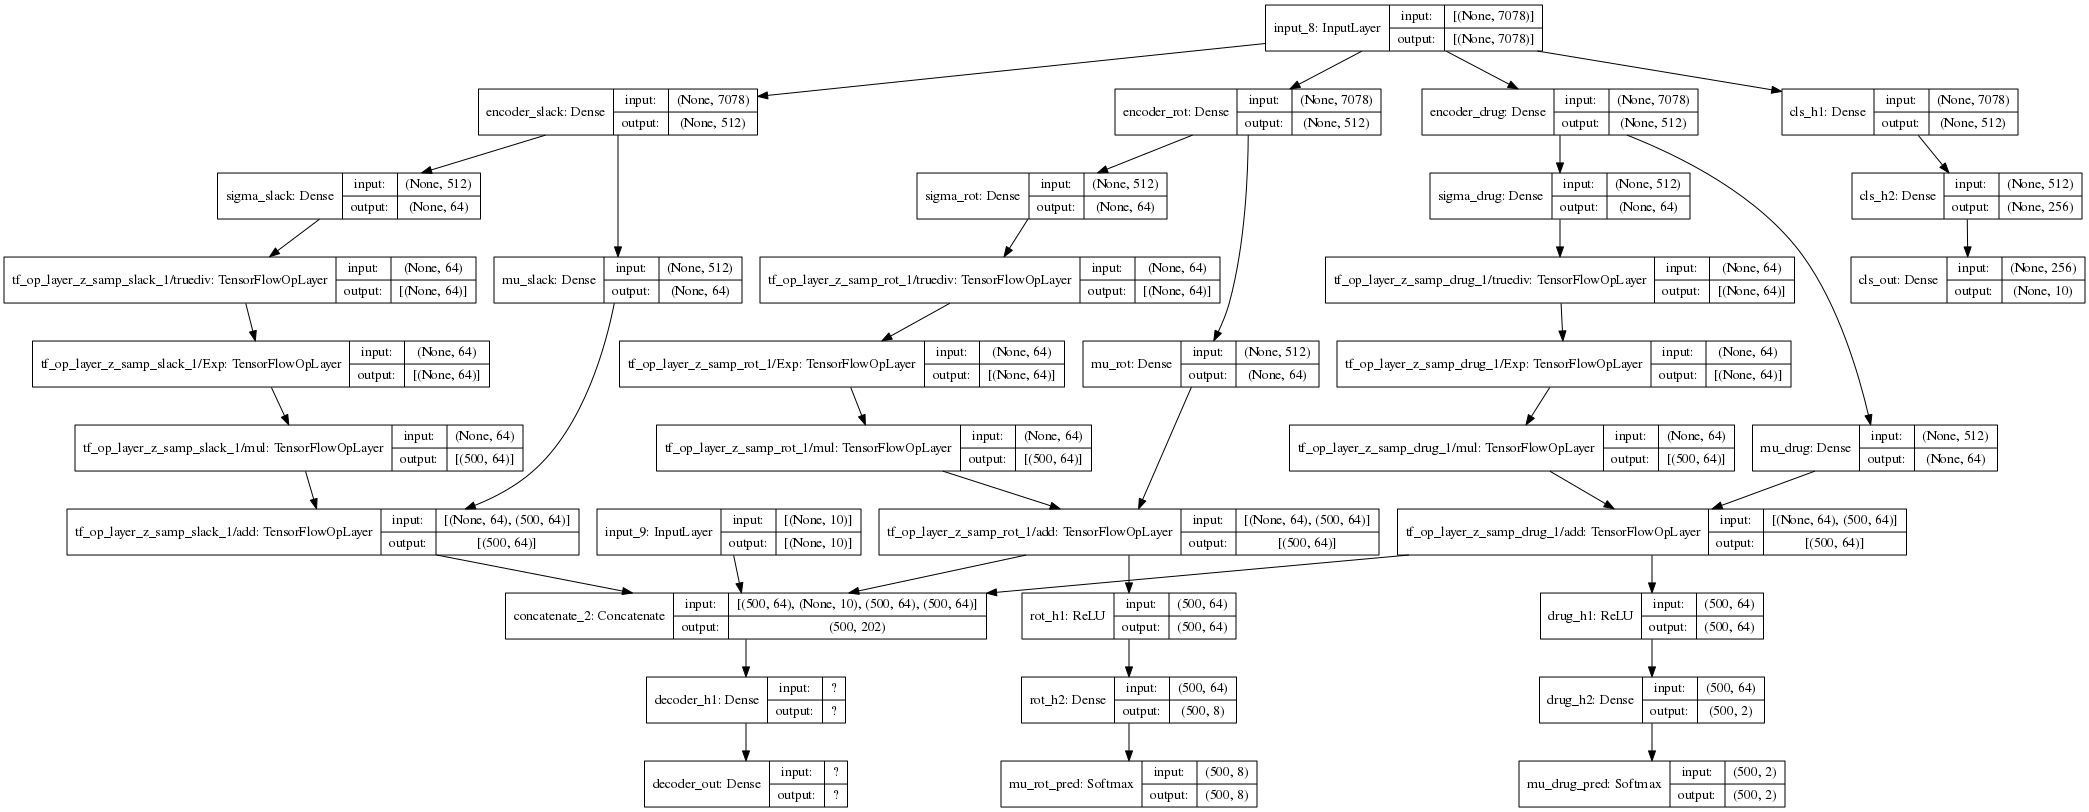

In [79]:
display(plot_model(known_prop_vae, show_layer_names=True, show_shapes=True, dpi=72))

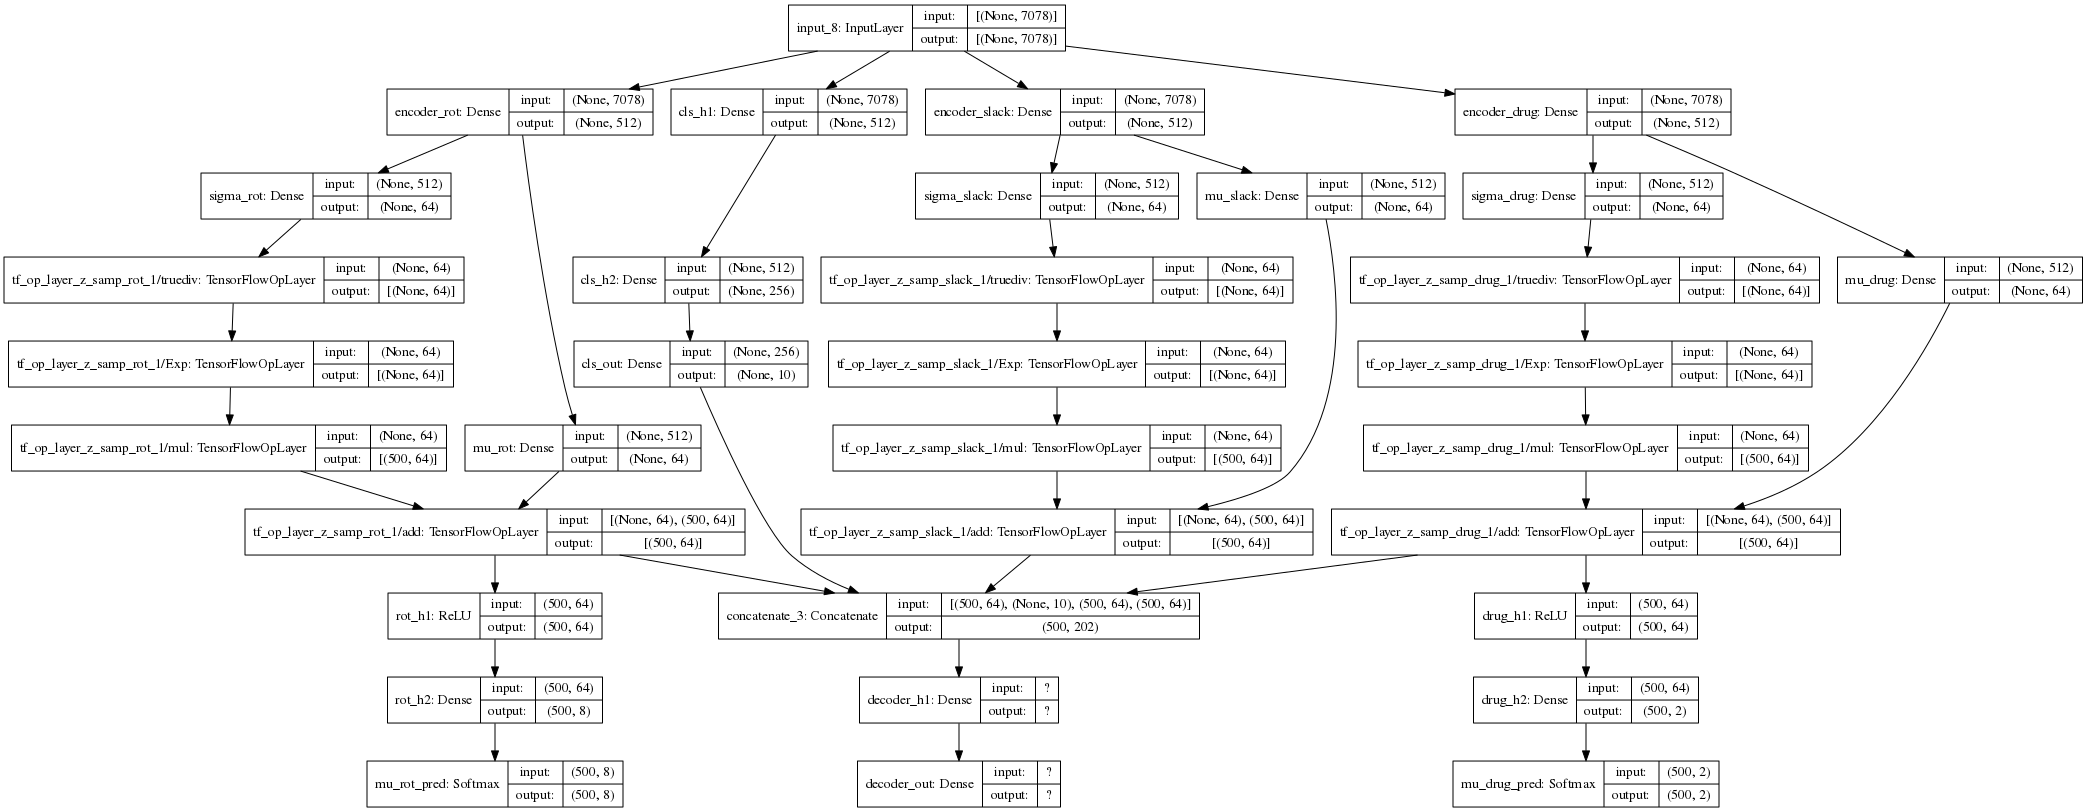

In [80]:
display(plot_model(unknown_prop_vae, show_layer_names=True, show_shapes=True, dpi=72))

# **Training**

Here we train using both the known and unknown cell-type proportions.
The labeled data is repeated in order to match the dimension of the unlabeled data so that they have the same batch size.
This code is taken from https://github.com/bjlkeng/sandbox/blob/master/notebooks/vae-semi_supervised_learning/vae-m2-fit-mnist.ipynb

In [81]:


def fit_model(X_unknown_prop, label_unknown_prop, drug_unknown_prop, X_known_prop, Y_known_prop, label_known_prop, drug_known_prop, epochs):
    assert len(X_unknown_prop) % len(X_known_prop) == 0, \
            (len(X_unknown_prop), batch_size, len(X_known_prop))
    start = time.time()
    history = []
    meta_hist = []
    
    for epoch in range(epochs):
        unlabeled_index = np.arange(len(X_unknown_prop))
        np.random.shuffle(unlabeled_index)

        # Repeat the unlabeled data to match length of labeled data
        labeled_index = []
        for i in range(len(X_unknown_prop) // len(X_known_prop)):
            l = np.arange(len(X_known_prop))
            np.random.shuffle(l)
            labeled_index.append(l)
        labeled_index = np.concatenate(labeled_index)
        
        batches = len(X_unknown_prop) // batch_size
        for i in range(batches):
            # Labeled
            index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
            loss = known_prop_vae.train_on_batch([X_known_prop[index_range], Y_known_prop[index_range]],
                                                    [X_known_prop[index_range], Y_known_prop[index_range], label_known_prop[index_range], drug_known_prop[index_range]])
            meta_hist.append(i)

            # Unlabeled
            index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
            loss += [unknown_prop_vae.train_on_batch(X_unknown_prop[index_range],
                                                        [X_unknown_prop[index_range], label_unknown_prop[index_range], drug_unknown_prop[index_range]])]

            meta_hist.append(i)

            history.append(loss)
            
    
   
    done = time.time()
    elapsed = done - start
    print("Elapsed: ", elapsed)
    
    return [history, meta_hist]

In [82]:
for layer in classifier.layers:
    print(layer)

In [83]:
for layer in encoder_unlab.layers:
    print(layer.name)

input_8
encoder_slack
encoder_rot
encoder_drug
sigma_slack
sigma_rot
sigma_drug
tf_op_layer_z_samp_slack_1/truediv
tf_op_layer_z_samp_rot_1/truediv
tf_op_layer_z_samp_drug_1/truediv
tf_op_layer_z_samp_slack_1/Exp
tf_op_layer_z_samp_rot_1/Exp
tf_op_layer_z_samp_drug_1/Exp
mu_slack
tf_op_layer_z_samp_slack_1/mul
mu_rot
tf_op_layer_z_samp_rot_1/mul
mu_drug
tf_op_layer_z_samp_drug_1/mul
tf_op_layer_z_samp_slack_1/add
tf_op_layer_z_samp_rot_1/add
tf_op_layer_z_samp_drug_1/add


Now train

In [84]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df


In [85]:
X_unkp.shape

(120, 7078)

In [86]:
x = np.array([[1,2],[3,4]])
x

array([[1, 2],
       [3, 4]])

In [87]:
# X_unknown_prop, label_unknown_prop, X_known_prop, Y_known_prop, label_known_prop
loss_history = fit_model(np.repeat(X_unkp, 100, axis=0),
                    np.repeat(label_unkp, 100, axis=0),
                    np.repeat(drug_unkp, 100, axis=0),
                    X_kp, 
                    y_kp,
                    label_kp, 
                    drug_kp, epochs=n_epoch)



Elapsed:  1675.671616077423


In [88]:
meta_history = loss_history[1]
loss_history = loss_history[0]

# Plot Loss Curves

In [89]:
# write out the loss for later plotting
# unpack the loss values
labeled_total_loss = [item[0] for item in loss_history]
unlabeled_total_loss = [item[5][0] for item in loss_history]

labeled_recon_loss = [item[1] for item in loss_history]
unlabeled_recon_loss = [item[5][1] for item in loss_history]

labeled_prop_loss = [item[2] for item in loss_history]

labeled_samp_loss = [item[3] for item in loss_history]
unlabeled_samp_loss = [item[5][2] for item in loss_history]

labeled_drug_loss = [item[4] for item in loss_history]
unlabeled_drug_loss = [item[5][2] for item in loss_history]


# make into a dataframe
total_loss = labeled_total_loss + unlabeled_total_loss + [a + b for a, b in zip(labeled_total_loss, unlabeled_total_loss)]
loss_df = pd.DataFrame(data=total_loss, columns=['total_loss'])
loss_df['type'] = ["labeled"]*len(loss_history) + ["unlabeled"]*len(loss_history) + ["sum"]*len(loss_history)
loss_df['batch'] = [*range(len(loss_history))] + [*range(len(loss_history))] + [*range(len(loss_history))]

recon_loss = labeled_recon_loss + unlabeled_recon_loss + [a + b for a, b in zip(labeled_recon_loss, unlabeled_recon_loss)]
loss_df['recon_loss'] = recon_loss

prop_loss = labeled_prop_loss + [0]*len(loss_history) + labeled_prop_loss
loss_df['prop_loss'] = prop_loss

samp_loss = labeled_samp_loss + unlabeled_samp_loss + [a + b for a, b in zip(labeled_samp_loss, unlabeled_samp_loss)]
loss_df['samp_loss'] = samp_loss


drug_loss = labeled_drug_loss + unlabeled_drug_loss + [a + b for a, b in zip(labeled_drug_loss, unlabeled_drug_loss)]
loss_df['drug_loss'] = drug_loss



In [90]:
loss_df

total_loss     type  batch     recon_loss    prop_loss     samp_loss  \
0      6.100637e+06  labeled      0    4605.096191  5831.548828  4.157705e+06   
1      1.765506e+06  labeled      1   71604.617188  5925.207031  1.687976e+06   
2      1.198238e+06  labeled      2  130099.117188  6380.256836  1.061759e+06   
3      8.968022e+05  labeled      3  173095.718750  6293.218750  7.174132e+05   
4      4.122784e+05  labeled      4  193148.093750  6730.161133  2.124001e+05   
...             ...      ...    ...            ...          ...           ...   
10795  5.345383e+04      sum   3595   52060.898438   305.912567  3.432735e+02   
10796  5.281517e+04      sum   3596   51076.437500   271.523285  3.113009e+02   
10797  5.285051e+04      sum   3597   51646.562500   316.275848  3.422507e+02   
10798  5.239852e+04      sum   3598   51240.906250   270.831238  3.359144e+02   
10799  5.297602e+04      sum   3599   51604.601562   346.360718  2.815125e+02   

          drug_loss  
0      1.932495e+06  
1      1.890924e-01  
2      4.168372e-05  
3      4.043603e-06  
4      2.539805e-07  
...             ...  
10795  4.564753e+02  
10796  5.292179e+02  
10797  4.304578e+02  
10798  4.710273e+02  
10799  4.276354e+02  

[10800 rows x 7 columns]

In [91]:
def read_loss_file(res_path, exp_id, unlab_id):
    loss_file = os.path.join(res_path, f"train-{exp_id}-{unlab_id}-DIVA_loss.pkl")
    loss_path = Path(loss_file)
    loss_df = pickle.load( open( loss_path, "rb" ) )
    return loss_df

def make_loss_fig(loss_df, ax, title, loss_to_plot):
    ## plot loss
    g = sns.lineplot(
        x="batch", y=loss_to_plot,
        data=loss_df,
        hue="type",
        legend="full",
        alpha=0.3, ax= ax
    )
    ax.set_title(title)
    return g

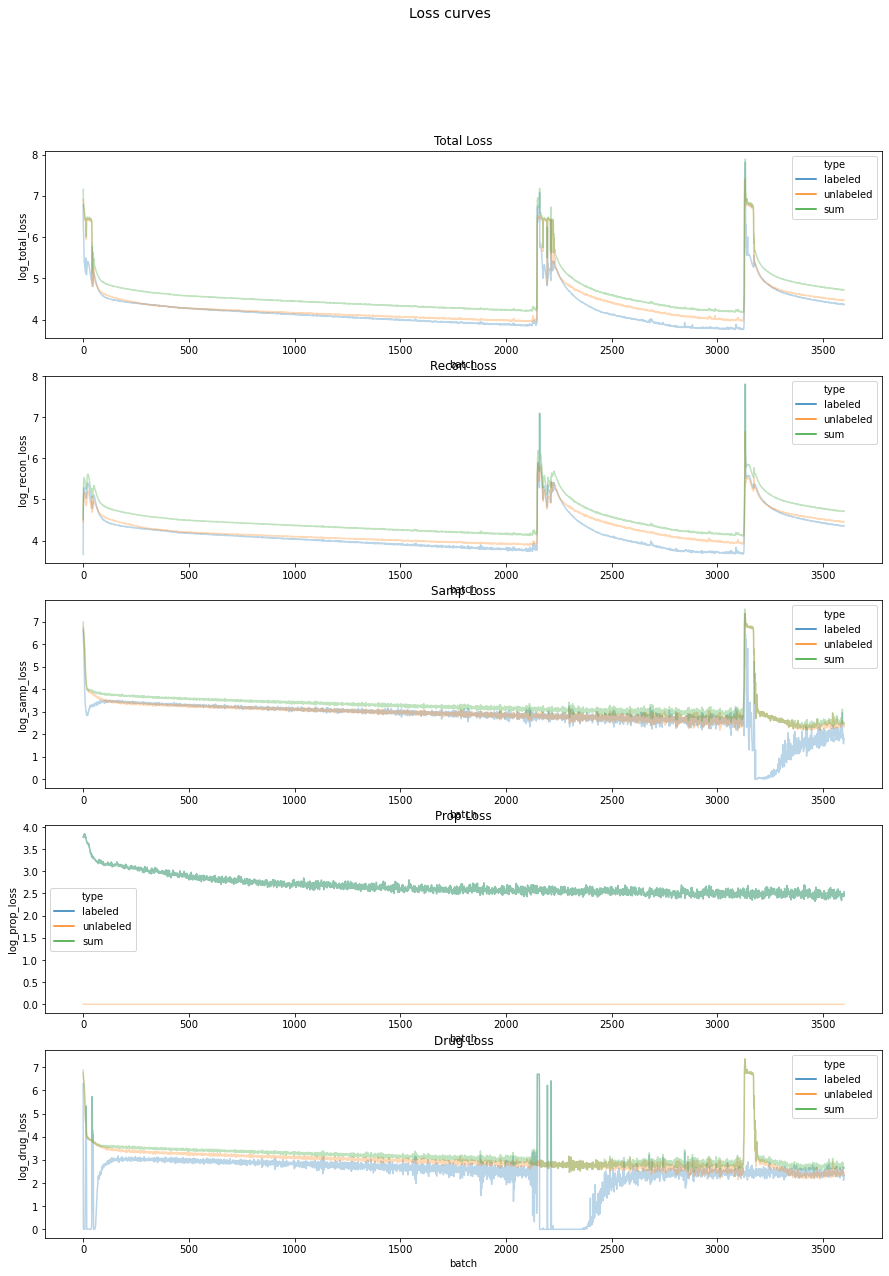

In [92]:

# add the log to make it easier to plot
loss_df["log_total_loss"] = np.log10(loss_df["total_loss"]+1)
loss_df["log_recon_loss"] = np.log10(loss_df["recon_loss"]+1)
loss_df["log_samp_loss"] = np.log10(loss_df["samp_loss"]+1)
loss_df["log_prop_loss"] = np.log10(loss_df["prop_loss"]+1)
loss_df["log_drug_loss"] = np.log10(loss_df["drug_loss"]+1)


fig, axs = plt.subplots(5, figsize=(15,20))

make_loss_fig(loss_df, ax=axs[0], title=f"Total Loss", loss_to_plot="log_total_loss")
make_loss_fig(loss_df, ax=axs[1], title=f"Recon Loss", loss_to_plot="log_recon_loss")
make_loss_fig(loss_df, ax=axs[2], title=f"Samp Loss", loss_to_plot="log_samp_loss")
make_loss_fig(loss_df, ax=axs[3], title=f"Prop Loss", loss_to_plot="log_prop_loss")
make_loss_fig(loss_df, ax=axs[4], title=f"Drug Loss", loss_to_plot="log_drug_loss")


fig.suptitle("Loss curves", fontsize=14)

fig.show()

In [93]:
def plot_cell_specific_corr(xval, yval, ax, title, xlab, ylab, class_id):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax,
        hue=class_id
    )
    g.set(ylim=(0, 1))
    g.set(xlim=(0, 1))
    g.plot([0, 1], [0, 1], transform=g.transAxes)

    ax.set_title(title)
    return g


def read_bp_result_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df

def read_bp_init_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


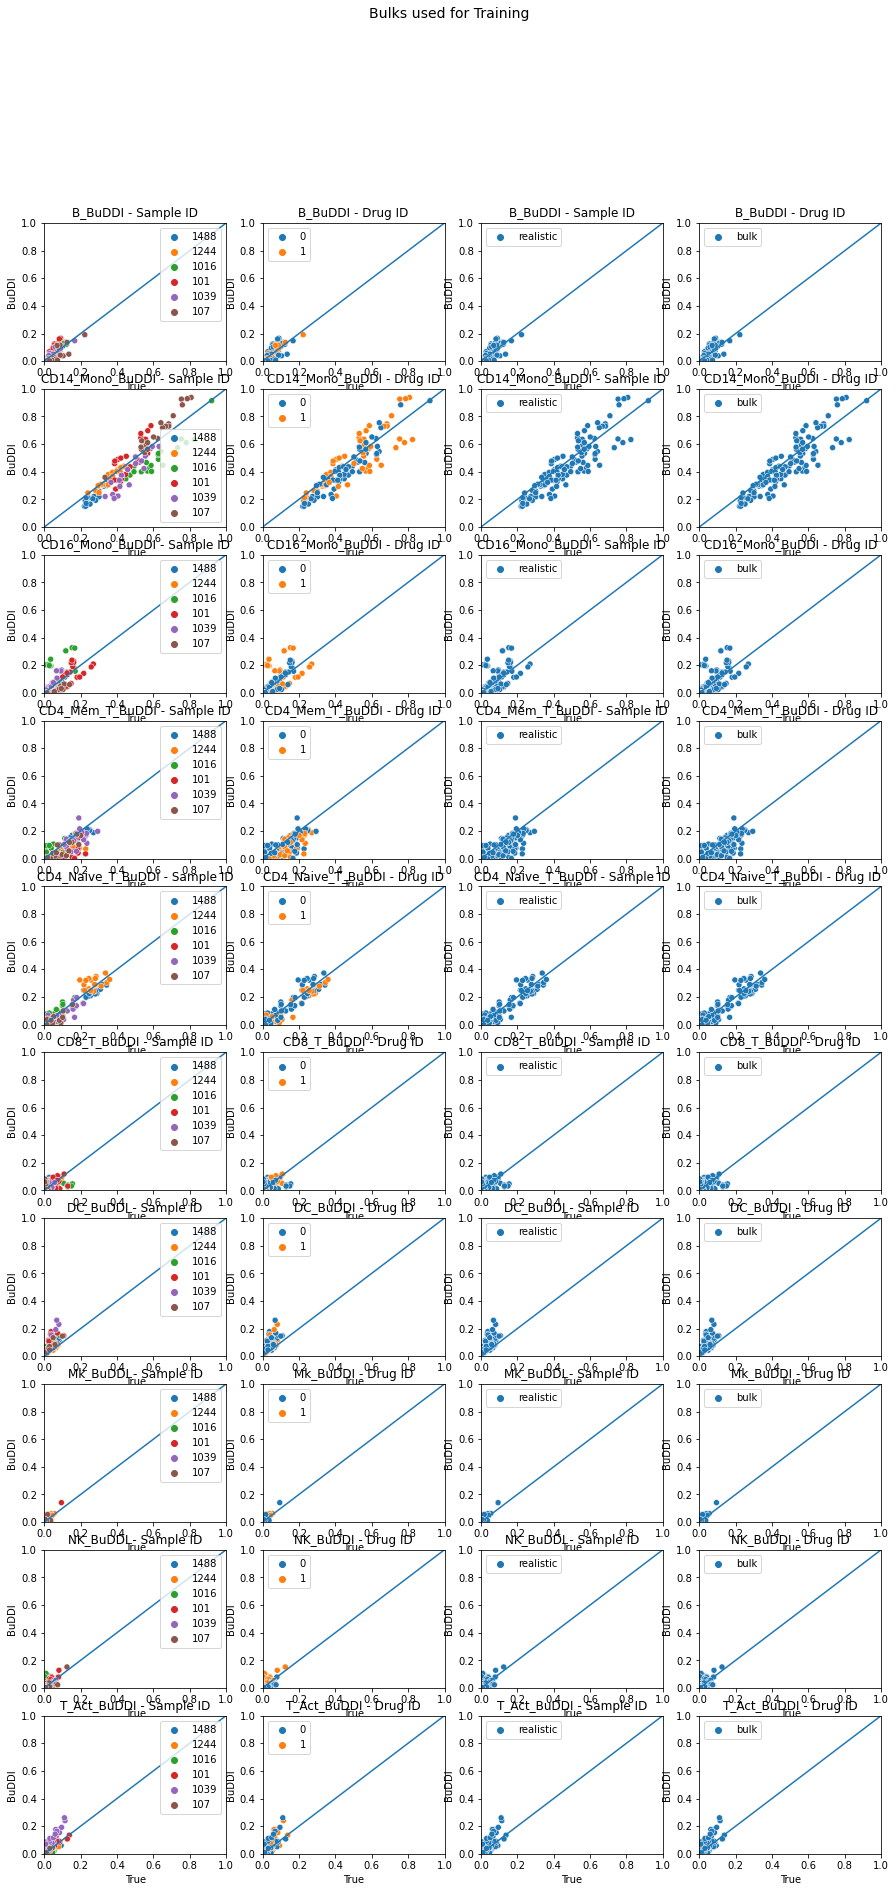

In [94]:
idx_tmp = np.intersect1d(idx_bulk, idx_train)
X_tmp = X_full[idx_tmp,]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

## plot for the unlabeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_full.columns)
true_prop_df = Y_full.iloc[idx_tmp]

label_temp = np.copy(Label_full)
label_temp = index_label[label_temp]



fig, axs = plt.subplots(10, 4, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=label_temp[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,2], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=meta_df.cell_prop_type.to_numpy()[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,3], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=meta_df.samp_type.to_numpy()[idx_tmp])
        
    row_idx = row_idx +1


fig.suptitle("Bulks used for Training", fontsize=14)

fig.show()

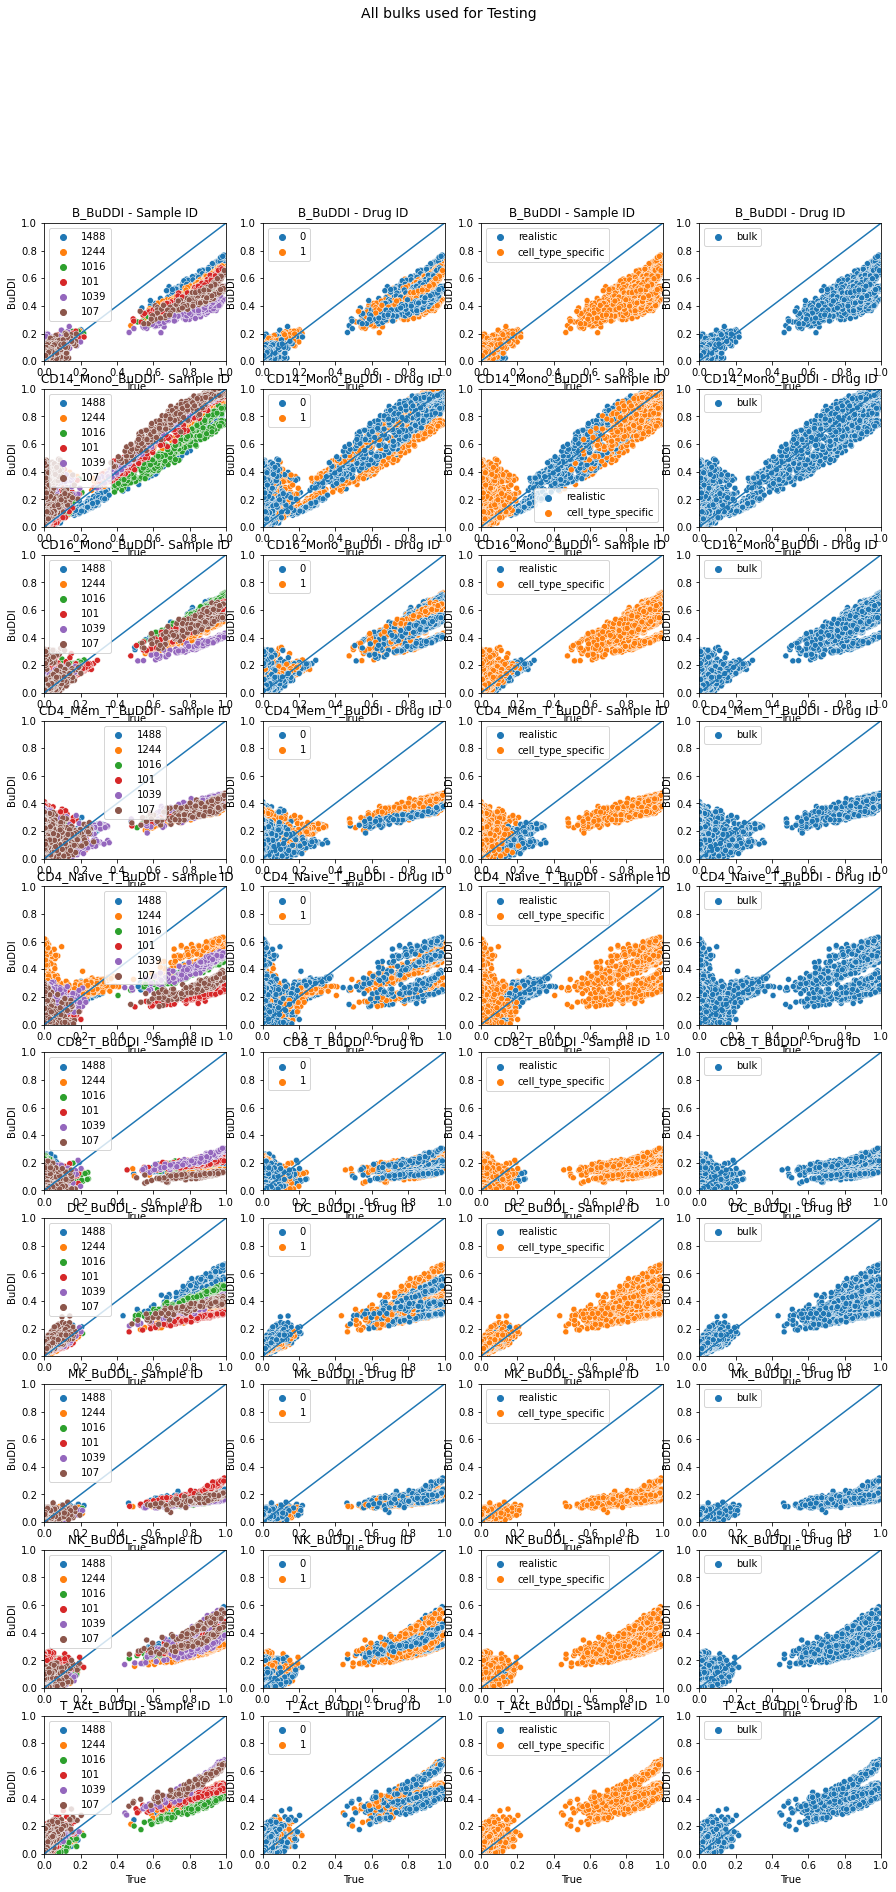

In [95]:
idx_tmp = idx_test
X_tmp = X_full[idx_tmp,]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

## plot for the unlabeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_full.columns)
true_prop_df = Y_full.iloc[idx_tmp]

label_temp = np.copy(Label_full)
label_temp = index_label[label_temp]



fig, axs = plt.subplots(10, 4, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=label_temp[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,2], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=meta_df.cell_prop_type.to_numpy()[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,3], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=meta_df.samp_type.to_numpy()[idx_tmp])
    row_idx = row_idx +1


fig.suptitle("All bulks used for Testing", fontsize=14)

fig.show()

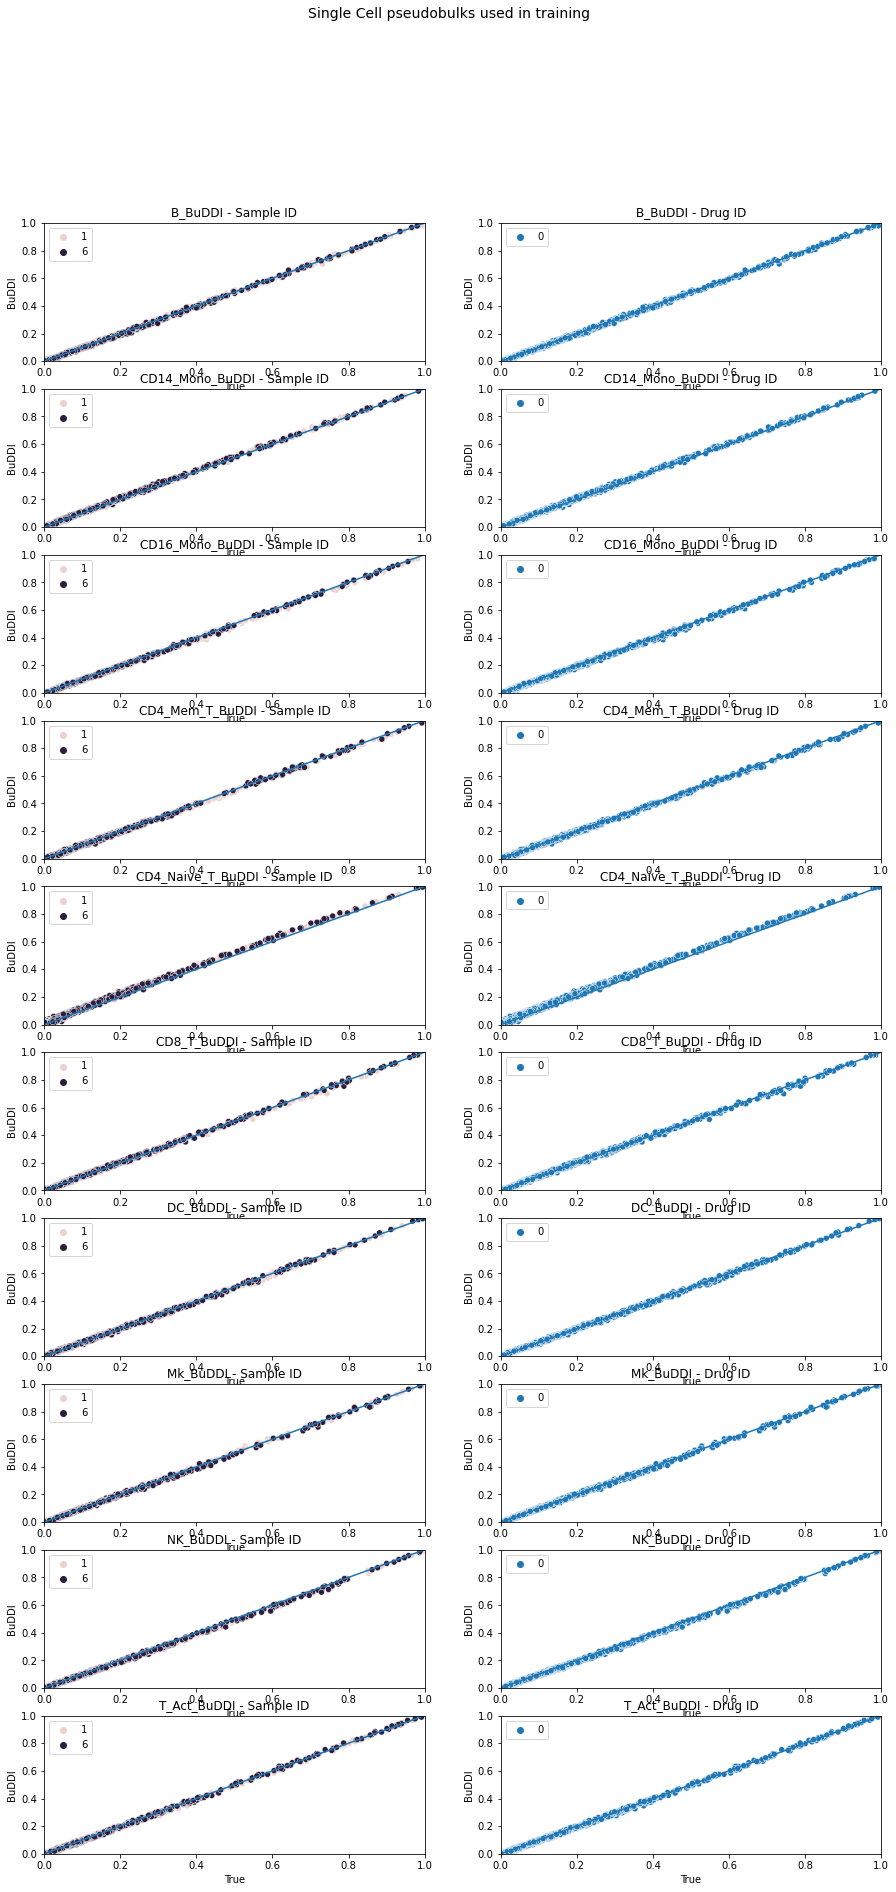

In [96]:
idx_tmp = idx_sc
X_tmp = X_full[idx_tmp,]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

## plot for the unlabeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_full.columns)
true_prop_df = Y_full.iloc[idx_tmp]

fig, axs = plt.subplots(10, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=Label_full[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_tmp])
    row_idx = row_idx +1


fig.suptitle("Single Cell pseudobulks used in training", fontsize=14)

fig.show()

### compare errors

In [97]:
def read_diva_result_file(res_path, train_id, test_id, unlab_id):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-DIVA.pkl")
    res_path = Path(res_file)
    res_df = pickle.load( open( res_path, "rb" ) )
    return res_df

def read_bp_result_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df

def read_bp_init_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df




In [98]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df


def get_errors_single(y_true, y_est):
  mse_err = [mean_sqr_error(y_true, y_est)]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true, y_est)[0]]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true, y_est)[0]]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"] + ["SPR"] + ["PEAR"]

  return plot_df




In [99]:
meta_df

sample_id  stim isTraining      cell_prop_type samp_type  Y_max
0         1015  CTRL      Train              random    sc_ref  T_Act
1         1015  CTRL      Train              random    sc_ref      B
2         1015  CTRL      Train              random    sc_ref     DC
3         1015  CTRL      Train              random    sc_ref     DC
4         1015  CTRL      Train              random    sc_ref      B
...        ...   ...        ...                 ...       ...    ...
1095       107  CTRL       Test  cell_type_specific      bulk     NK
1096       107  CTRL       Test  cell_type_specific      bulk     NK
1097       107  CTRL       Test  cell_type_specific      bulk     NK
1098       107  CTRL       Test  cell_type_specific      bulk     NK
1099       107  CTRL       Test  cell_type_specific      bulk     NK

[15320 rows x 6 columns]

MSqE mean: 0.002107563217350977, median: 0.0017152379317662905, max: 0.010726853297036045
Spearman mean: 0.719191919191919, median: 0.7878787878787878, max: 0.9636363636363635
Pearson mean: 0.9314654105614041, median: 0.9603387091290372, max: 0.996137765341722
MSqE mean: 0.0027859907872237913, median: 0.0018050077264637502, max: 0.00836336622956078
Spearman mean: 0.7054545454545453, median: 0.7393939393939393, max: 0.9636363636363635
Pearson mean: 0.9435197349055003, median: 0.958634940446607, max: 0.9979169308850927


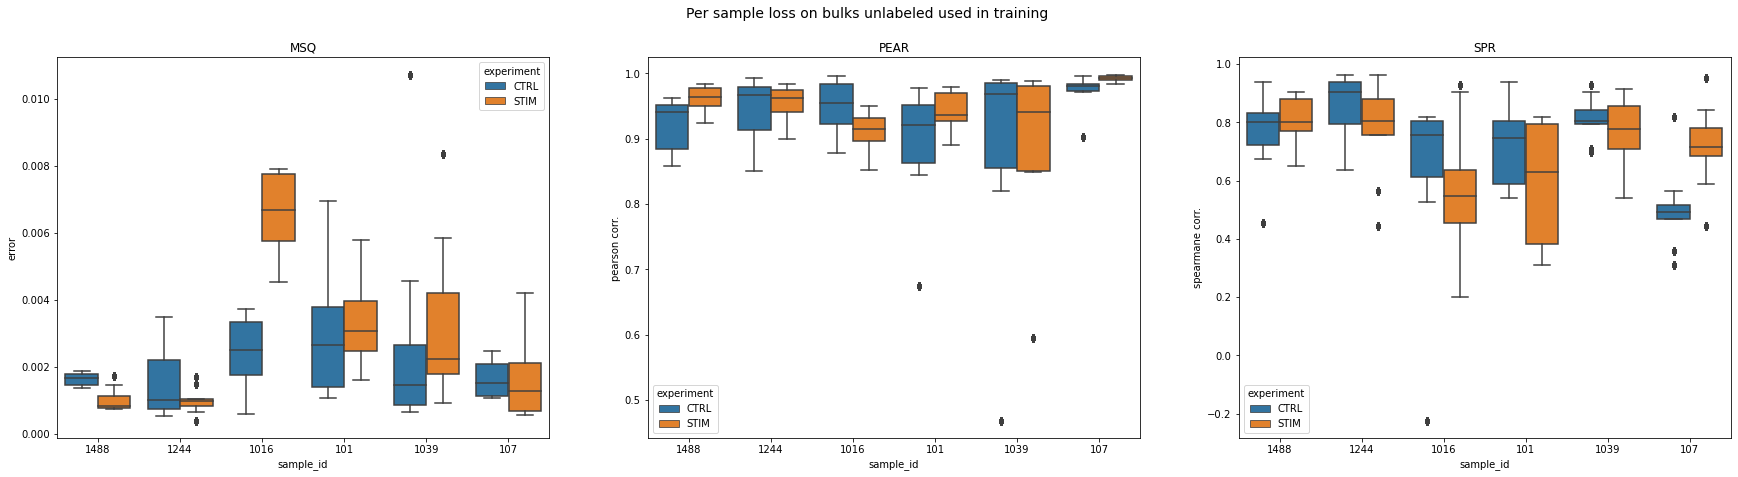

In [100]:
# Now compare across samples
idx_tmp = np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "CTRL")
idx_tmp = np.where( idx_tmp)[0]
idx_tmp = np.tile(idx_tmp, 100)


X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err_ctrl = get_errors(Y_tmp.to_numpy(), prop_outputs)


# format the errors
buddi_err_ctrl["experiment"] = ["CTRL"]*buddi_err_ctrl.shape[0]
buddi_err_ctrl["method"] = ["BuDDI"]*buddi_err_ctrl.shape[0]
buddi_err_ctrl["sample_id"] = np.tile(samp_ids, 3)


# Now compare across samples
idx_tmp = np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "STIM")
idx_tmp = np.where( idx_tmp)[0]
idx_tmp = np.tile(idx_tmp, 100)


X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err_stim = get_errors(Y_tmp.to_numpy(), prop_outputs)


# format the errors
buddi_err_stim["experiment"] = ["STIM"]*buddi_err_stim.shape[0]
buddi_err_stim["method"] = ["BuDDI"]*buddi_err_stim.shape[0]
buddi_err_stim["sample_id"] = np.tile(samp_ids, 3)

plot_df = pd.concat([buddi_err_ctrl, buddi_err_stim])



# plot
fig, axs = plt.subplots(1, 3, figsize=(30,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")


sns.boxplot(data=plot_df[plot_df["error_type"] == "SPR"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[2])
axs[2].set_title("SPR")
axs[2].set(ylabel="spearmane corr.")
fig.suptitle("Per sample loss on bulks unlabeled used in training", fontsize=14)

fig.show()

MSqE mean: 0.0019775373227148042, median: 0.0018646343832013506, max: 0.007506999268383581
Spearman mean: 0.7078787878787879, median: 0.7696969696969697, max: 0.9878787878787878
Pearson mean: 0.9570680285885568, median: 0.9660206388950058, max: 0.9990168808538957
MSqE mean: 0.0016620800385728086, median: 0.0012460922638445242, max: 0.006856835192815873
Spearman mean: 0.7638787878787877, median: 0.7939393939393938, max: 0.9878787878787878
Pearson mean: 0.9685845795187318, median: 0.9728002609581118, max: 0.9997928026974676


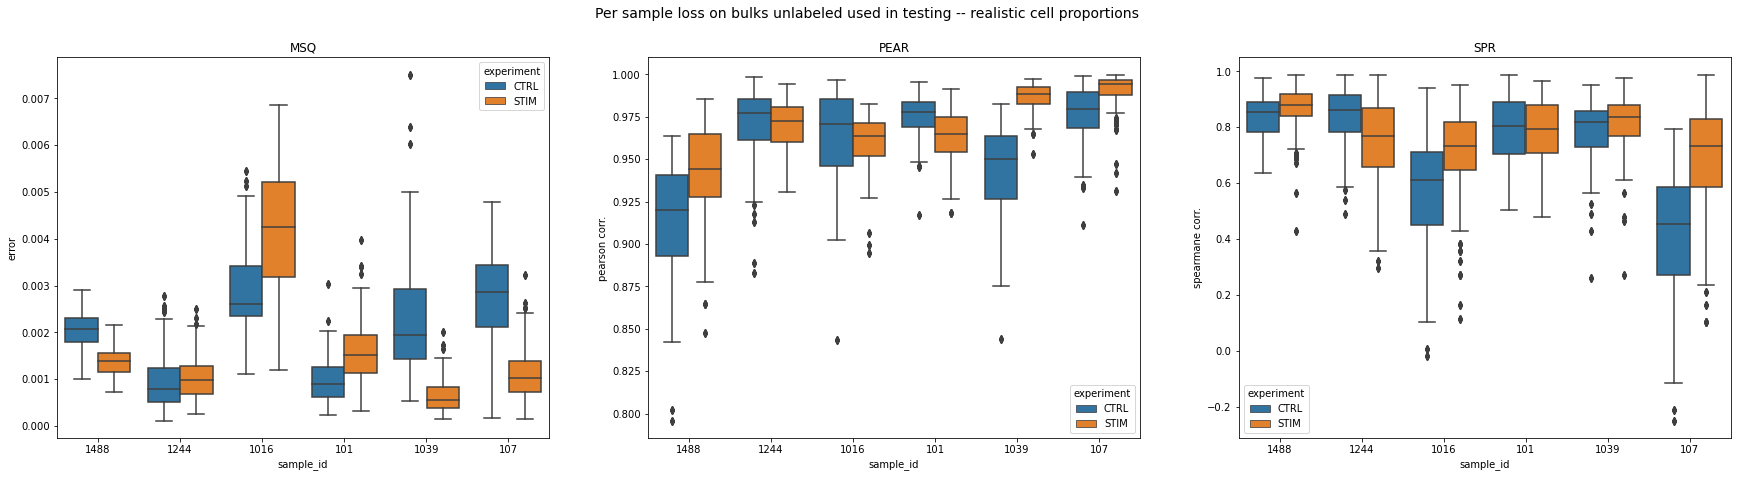

In [101]:
# Now compare across samples
idx_tmp = np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Test")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "CTRL")
idx_tmp = np.logical_and(idx_tmp, meta_df.cell_prop_type == "realistic")
idx_tmp = np.where( idx_tmp)[0]
idx_tmp = np.tile(idx_tmp, 5)


X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err_ctrl = get_errors(Y_tmp.to_numpy(), prop_outputs)


# format the errors
buddi_err_ctrl["experiment"] = ["CTRL"]*buddi_err_ctrl.shape[0]
buddi_err_ctrl["method"] = ["BuDDI"]*buddi_err_ctrl.shape[0]
buddi_err_ctrl["sample_id"] = np.tile(samp_ids, 3)


# Now compare across samples
idx_tmp = np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Test")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "STIM")
idx_tmp = np.logical_and(idx_tmp, meta_df.cell_prop_type == "realistic")
idx_tmp = np.where( idx_tmp)[0]
idx_tmp = np.tile(idx_tmp, 5)


X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err_stim = get_errors(Y_tmp.to_numpy(), prop_outputs)


# format the errors
buddi_err_stim["experiment"] = ["STIM"]*buddi_err_stim.shape[0]
buddi_err_stim["method"] = ["BuDDI"]*buddi_err_stim.shape[0]
buddi_err_stim["sample_id"] = np.tile(samp_ids, 3)

plot_df = pd.concat([buddi_err_ctrl, buddi_err_stim])



# plot
fig, axs = plt.subplots(1, 3, figsize=(30,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")


sns.boxplot(data=plot_df[plot_df["error_type"] == "SPR"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[2])
axs[2].set_title("SPR")
axs[2].set(ylabel="spearmane corr.")
fig.suptitle("Per sample loss on bulks unlabeled used in testing -- realistic cell proportions", fontsize=14)

fig.show()

MSqE mean: 0.031200782397093518, median: 0.02838396951097145, max: 0.10668854035757289
Spearman mean: 0.38517575757575756, median: 0.406060606060606, max: 0.9878787878787878
Pearson mean: 0.742191299970245, median: 0.8324406304996437, max: 0.9998574847520332
MSqE mean: 0.030655437085091393, median: 0.027436352241427153, max: 0.09348502819552326
Spearman mean: 0.3937454545454545, median: 0.406060606060606, max: 0.9878787878787878
Pearson mean: 0.749099949357675, median: 0.8556954472454898, max: 0.9999702383075381


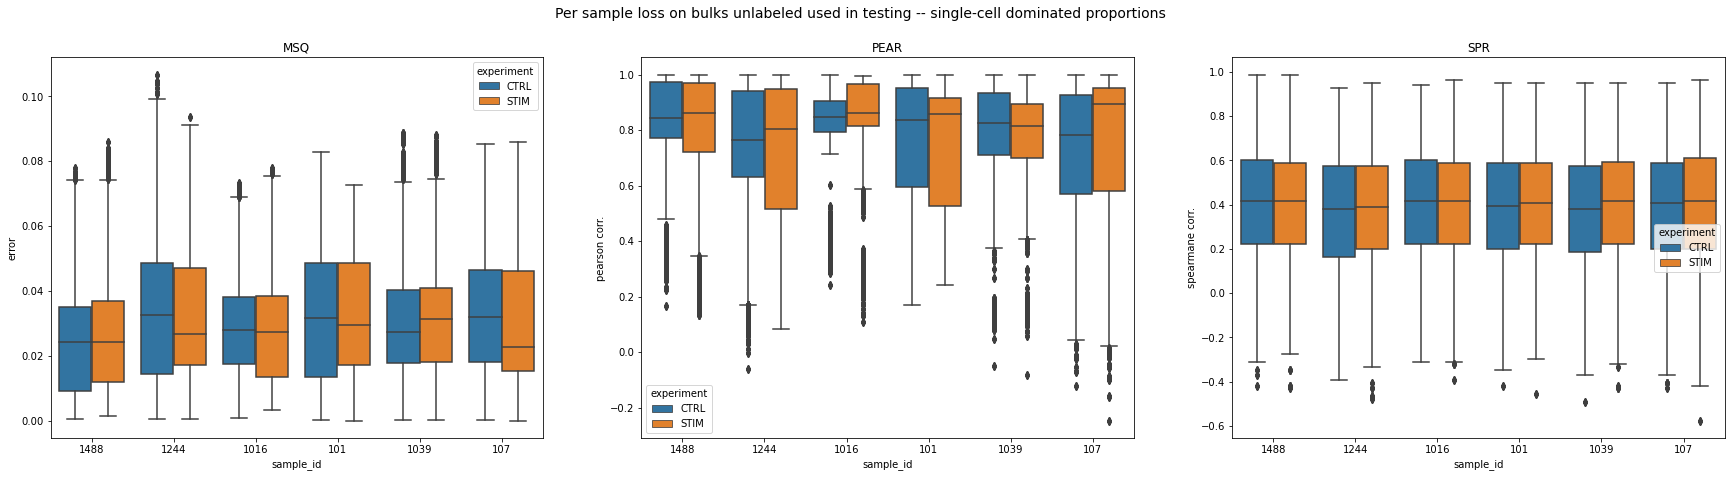

In [102]:
# Now compare across samples
idx_tmp = np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Test")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "CTRL")
idx_tmp = np.logical_and(idx_tmp, meta_df.cell_prop_type == "cell_type_specific")
idx_tmp = np.where( idx_tmp)[0]
idx_tmp = np.tile(idx_tmp, 5)


X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err_ctrl = get_errors(Y_tmp.to_numpy(), prop_outputs)


# format the errors
buddi_err_ctrl["experiment"] = ["CTRL"]*buddi_err_ctrl.shape[0]
buddi_err_ctrl["method"] = ["BuDDI"]*buddi_err_ctrl.shape[0]
buddi_err_ctrl["sample_id"] = np.tile(samp_ids, 3)


# Now compare across samples
idx_tmp = np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Test")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "STIM")
idx_tmp = np.logical_and(idx_tmp, meta_df.cell_prop_type == "cell_type_specific")
idx_tmp = np.where( idx_tmp)[0]
idx_tmp = np.tile(idx_tmp, 5)


X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err_stim = get_errors(Y_tmp.to_numpy(), prop_outputs)


# format the errors
buddi_err_stim["experiment"] = ["STIM"]*buddi_err_stim.shape[0]
buddi_err_stim["method"] = ["BuDDI"]*buddi_err_stim.shape[0]
buddi_err_stim["sample_id"] = np.tile(samp_ids, 3)

plot_df = pd.concat([buddi_err_ctrl, buddi_err_stim])



# plot
fig, axs = plt.subplots(1, 3, figsize=(30,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")


sns.boxplot(data=plot_df[plot_df["error_type"] == "SPR"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[2])
axs[2].set_title("SPR")
axs[2].set(ylabel="spearmane corr.")
fig.suptitle("Per sample loss on bulks unlabeled used in testing -- single-cell dominated proportions", fontsize=14)

fig.show()

# **Inspect the output**

## TSNE training data

Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

## Plot Reconstruction

In [103]:
recon_idx = np.logical_and(meta_df.cell_prop_type == "realistic", meta_df.isTraining == "Test")
recon_idx = np.where(recon_idx)[0]




Y_temp = np.copy(Y_full.iloc[recon_idx])
Y_temp = np.argmax(Y_temp, axis=1)


label_temp = np.copy(Label_full[recon_idx])
perturb_temp = Drug_full[recon_idx]

# need duplicates
len_recon_idx = len(recon_idx)
recon_idx = np.tile(recon_idx, 5)
X_temp = np.copy(X_full[recon_idx])


prop_outputs = classifier.predict(X_temp, batch_size=batch_size)



# now use the encoder to get the latent spaces
z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)

# now concatenate together
z_concat = np.hstack([z_slack, prop_outputs, z_rot, z_drug])

# and decode
decoded_outputs = decoder.predict(z_concat, batch_size=batch_size)

decoded_outputs = decoded_outputs[0:len_recon_idx]
X_temp = X_temp[0:len_recon_idx]


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


(1200, 2)
(1200, 2)


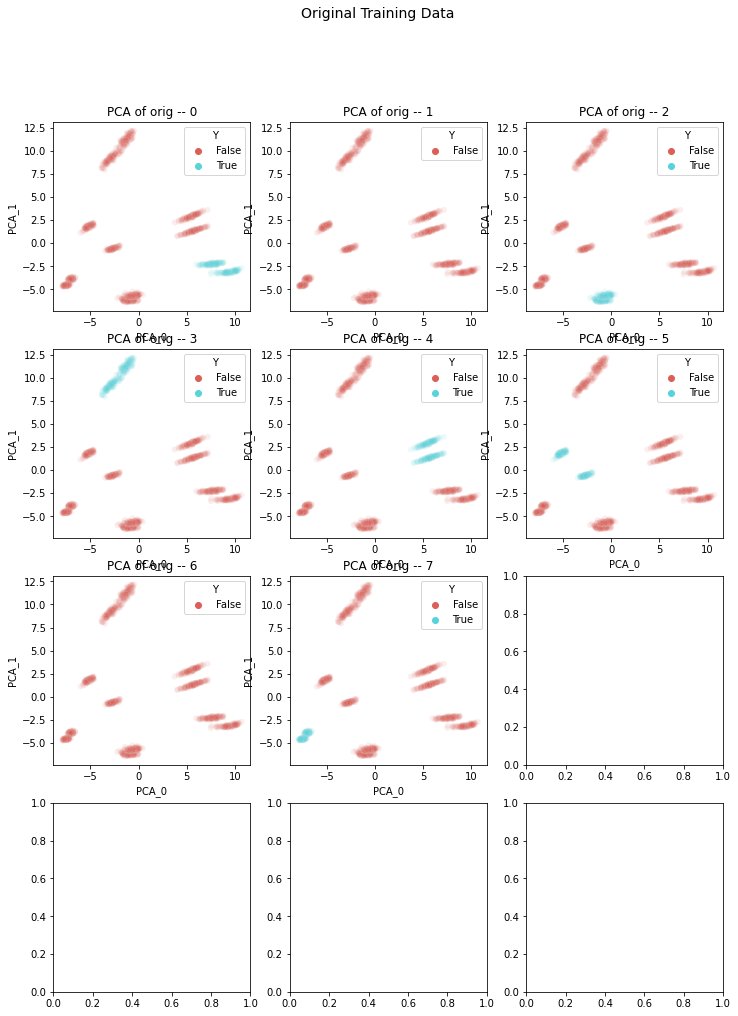

In [104]:

fig, axs = plt.subplots(4, 3, figsize=(12,16))

plot_df = vp.get_pca_for_plotting(np.asarray(X_temp))
vp.plot_pca(plot_df, color_vec=label_temp==0, ax=axs[0,0], title="PCA of orig -- 0")
vp.plot_pca(plot_df, color_vec=label_temp==1, ax=axs[0,1], title="PCA of orig -- 1")
vp.plot_pca(plot_df, color_vec=label_temp==2, ax=axs[0,2], title="PCA of orig -- 2")
vp.plot_pca(plot_df, color_vec=label_temp==3, ax=axs[1,0], title="PCA of orig -- 3")
vp.plot_pca(plot_df, color_vec=label_temp==4, ax=axs[1,1], title="PCA of orig -- 4")
vp.plot_pca(plot_df, color_vec=label_temp==5, ax=axs[1,2], title="PCA of orig -- 5")
vp.plot_pca(plot_df, color_vec=label_temp==6, ax=axs[2,0], title="PCA of orig -- 6")
vp.plot_pca(plot_df, color_vec=label_temp==7, ax=axs[2,1], title="PCA of orig -- 7")


fig.suptitle("Original Training Data", fontsize=14)

fig.show()

(1200, 2)
(1200, 2)


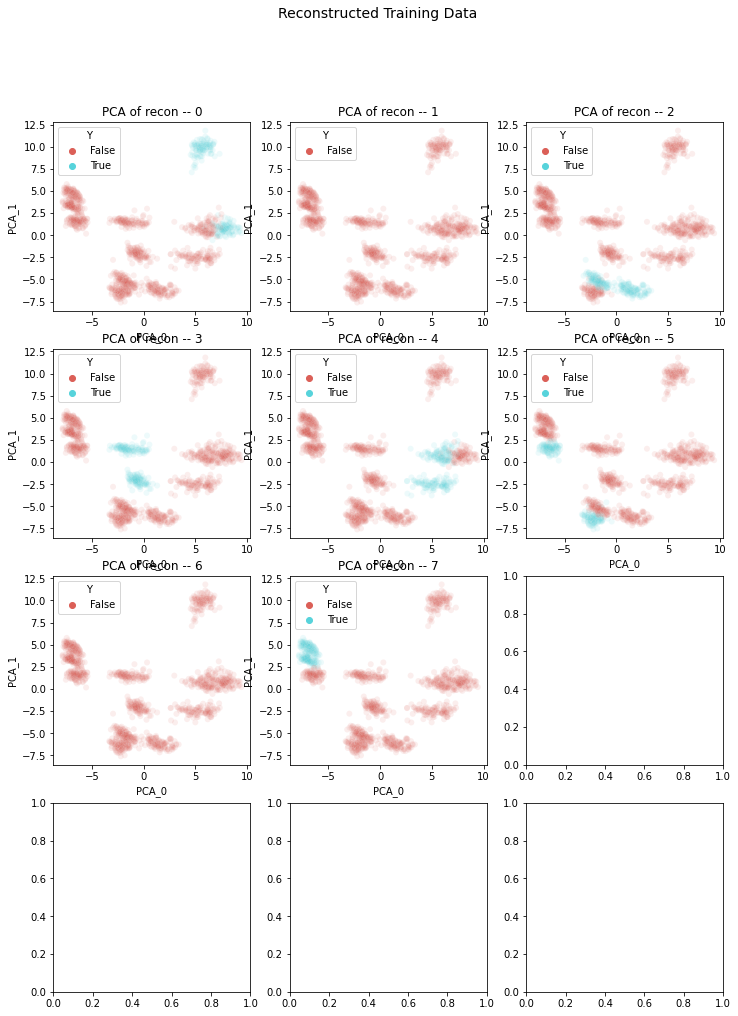

In [105]:

fig, axs = plt.subplots(4, 3, figsize=(12,16))

plot_df = vp.get_pca_for_plotting(np.asarray(decoded_outputs))
vp.plot_pca(plot_df, color_vec=label_temp==0, ax=axs[0,0], title="PCA of recon -- 0")
vp.plot_pca(plot_df, color_vec=label_temp==1, ax=axs[0,1], title="PCA of recon -- 1")
vp.plot_pca(plot_df, color_vec=label_temp==2, ax=axs[0,2], title="PCA of recon -- 2")
vp.plot_pca(plot_df, color_vec=label_temp==3, ax=axs[1,0], title="PCA of recon -- 3")
vp.plot_pca(plot_df, color_vec=label_temp==4, ax=axs[1,1], title="PCA of recon -- 4")
vp.plot_pca(plot_df, color_vec=label_temp==5, ax=axs[1,2], title="PCA of recon -- 5")
vp.plot_pca(plot_df, color_vec=label_temp==6, ax=axs[2,0], title="PCA of recon -- 6")
vp.plot_pca(plot_df, color_vec=label_temp==7, ax=axs[2,1], title="PCA of recon -- 7")


fig.suptitle("Reconstructed Training Data", fontsize=14)

fig.show()

In [106]:
X_temp

array([[8.06451613e-04, 0.00000000e+00, 5.24193548e-03, ...,
        3.87096774e-02, 1.79540710e-01, 0.00000000e+00],
       [8.06451613e-04, 0.00000000e+00, 4.83870968e-03, ...,
        3.58870968e-02, 2.33298539e-01, 0.00000000e+00],
       [1.20967742e-03, 0.00000000e+00, 4.83870968e-03, ...,
        2.54032258e-02, 8.45511482e-02, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 6.45161290e-03, ...,
        9.94758065e-01, 3.49686848e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.04838710e-03, ...,
        1.00000000e+00, 1.56576200e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.85483871e-03, ...,
        1.00000000e+00, 3.07933194e-02, 0.00000000e+00]])

In [107]:
decoded_outputs

array([[2.3471713e-03, 2.8343201e-03, 2.1413028e-02, ..., 9.9779636e-02,
        1.8145004e-01, 1.9901484e-02],
       [2.3458302e-03, 3.8757920e-03, 3.6068320e-02, ..., 1.2721452e-01,
        2.1388361e-01, 4.4243902e-02],
       [2.3005903e-03, 4.5193732e-03, 1.7227203e-02, ..., 1.1632094e-01,
        1.6843733e-01, 3.6179304e-02],
       ...,
       [1.3388425e-02, 5.6433678e-04, 7.7433288e-03, ..., 8.8816160e-01,
        2.0462692e-02, 4.1776925e-02],
       [9.4645321e-03, 4.0572882e-04, 6.4159930e-03, ..., 9.6472204e-01,
        1.2121975e-02, 2.9583812e-02],
       [2.0257384e-02, 1.6696453e-03, 1.2129277e-02, ..., 9.6886361e-01,
        1.7020613e-02, 3.1638086e-02]], dtype=float32)

(2400, 2)
(2400, 2)


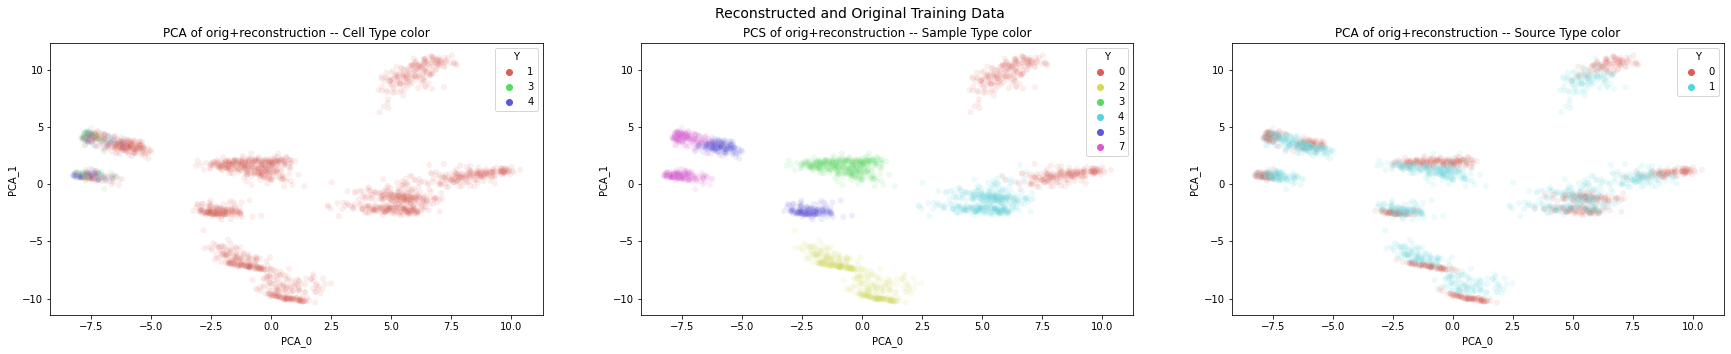

In [108]:
# make duplicated
X_dup = np.vstack([X_temp, decoded_outputs])


Y_dup = np.append(Y_temp, Y_temp)

label_dup = np.append(label_temp, label_temp)
perturb_dup = np.append(perturb_temp, perturb_temp)
source_dup = np.asarray(np.append([0]*1200, [1]*1200))

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = vp.get_pca_for_plotting(np.asarray(X_dup))
vp.plot_pca(plot_df, color_vec=Y_dup, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_dup, ax=axs[1], title="PCS of orig+reconstruction -- Sample Type color")
vp.plot_pca(plot_df, color_vec=source_dup, ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")


fig.suptitle("Reconstructed and Original Training Data", fontsize=14)

fig.show()

### Plot latent spaces

In [109]:
len(idx_train)

2120

Number unique Y: 10
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)


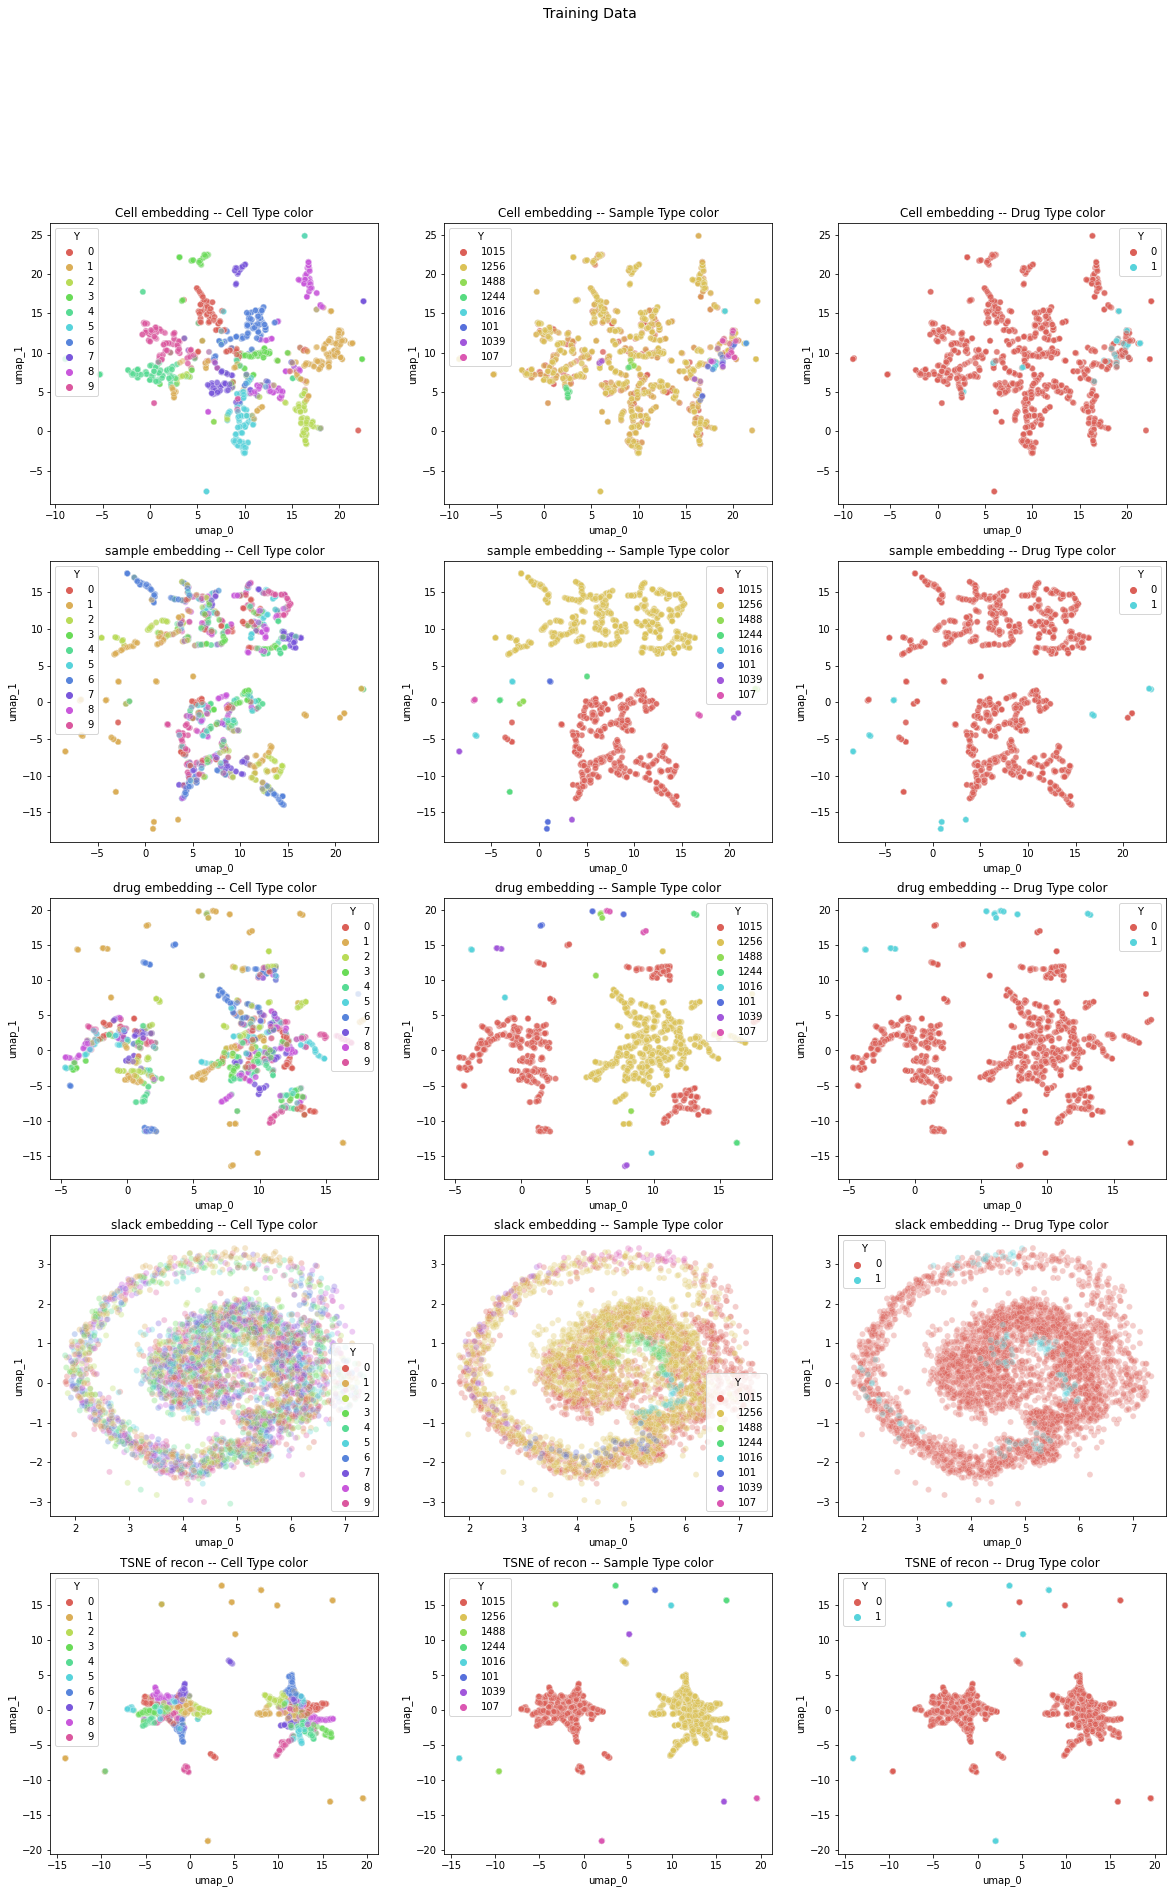

In [110]:
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data

idx_tmp = np.repeat(idx_train, 2)[240:4240]

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]

print(f"Number unique Y: {len(np.unique(Y_temp))}")


z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)
prop_outputs = classifier.predict(X_temp, batch_size=batch_size)


# now concatenate together
z_concat = np.hstack([z_slack, prop_outputs, z_rot, z_drug])

# and decode
decoded_outputs = decoder.predict(z_concat, batch_size=batch_size)


fig, axs = plt.subplots(5, 3, figsize=(20,30))

plot_df = vp.get_umap_for_plotting(np.asarray(prop_outputs))
vp.plot_umap(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
vp.plot_umap(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")
vp.plot_umap(plot_df, color_vec=perturb_temp, ax=axs[0,2], title="Cell embedding -- Drug Type color")

plot_df = vp.get_umap_for_plotting(np.asarray(mu_rot))
vp.plot_umap(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
vp.plot_umap(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")
vp.plot_umap(plot_df, color_vec=perturb_temp, ax=axs[1,2], title="sample embedding -- Drug Type color")

plot_df = vp.get_umap_for_plotting(np.asarray(mu_drug))
vp.plot_umap(plot_df, color_vec=Y_temp, ax=axs[2,0], title="drug embedding -- Cell Type color")
vp.plot_umap(plot_df, color_vec=label_temp, ax=axs[2,1], title="drug embedding -- Sample Type color")
vp.plot_umap(plot_df, color_vec=perturb_temp, ax=axs[2,2], title="drug embedding -- Drug Type color")

plot_df = vp.get_umap_for_plotting(np.asarray(mu_slack))
vp.plot_umap(plot_df, color_vec=Y_temp, ax=axs[3,0], title="slack embedding -- Cell Type color")
vp.plot_umap(plot_df, color_vec=label_temp, ax=axs[3,1], title="slack embedding -- Sample Type color")
vp.plot_umap(plot_df, color_vec=perturb_temp, ax=axs[3,2], title="slack embedding -- Drug Type color")

plot_df = vp.get_umap_for_plotting(np.asarray(decoded_outputs))
vp.plot_umap(plot_df, color_vec=Y_temp, ax=axs[4,0], title="TSNE of recon -- Cell Type color")
vp.plot_umap(plot_df, color_vec=label_temp, ax=axs[4,1], title="TSNE of recon -- Sample Type color")
vp.plot_umap(plot_df, color_vec=perturb_temp, ax=axs[4,2], title="TSNE of recon -- Drug Type color")




fig.suptitle("Training Data", fontsize=14)

fig.show()

Number unique Y: 10
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:595: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var.sum()


(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)


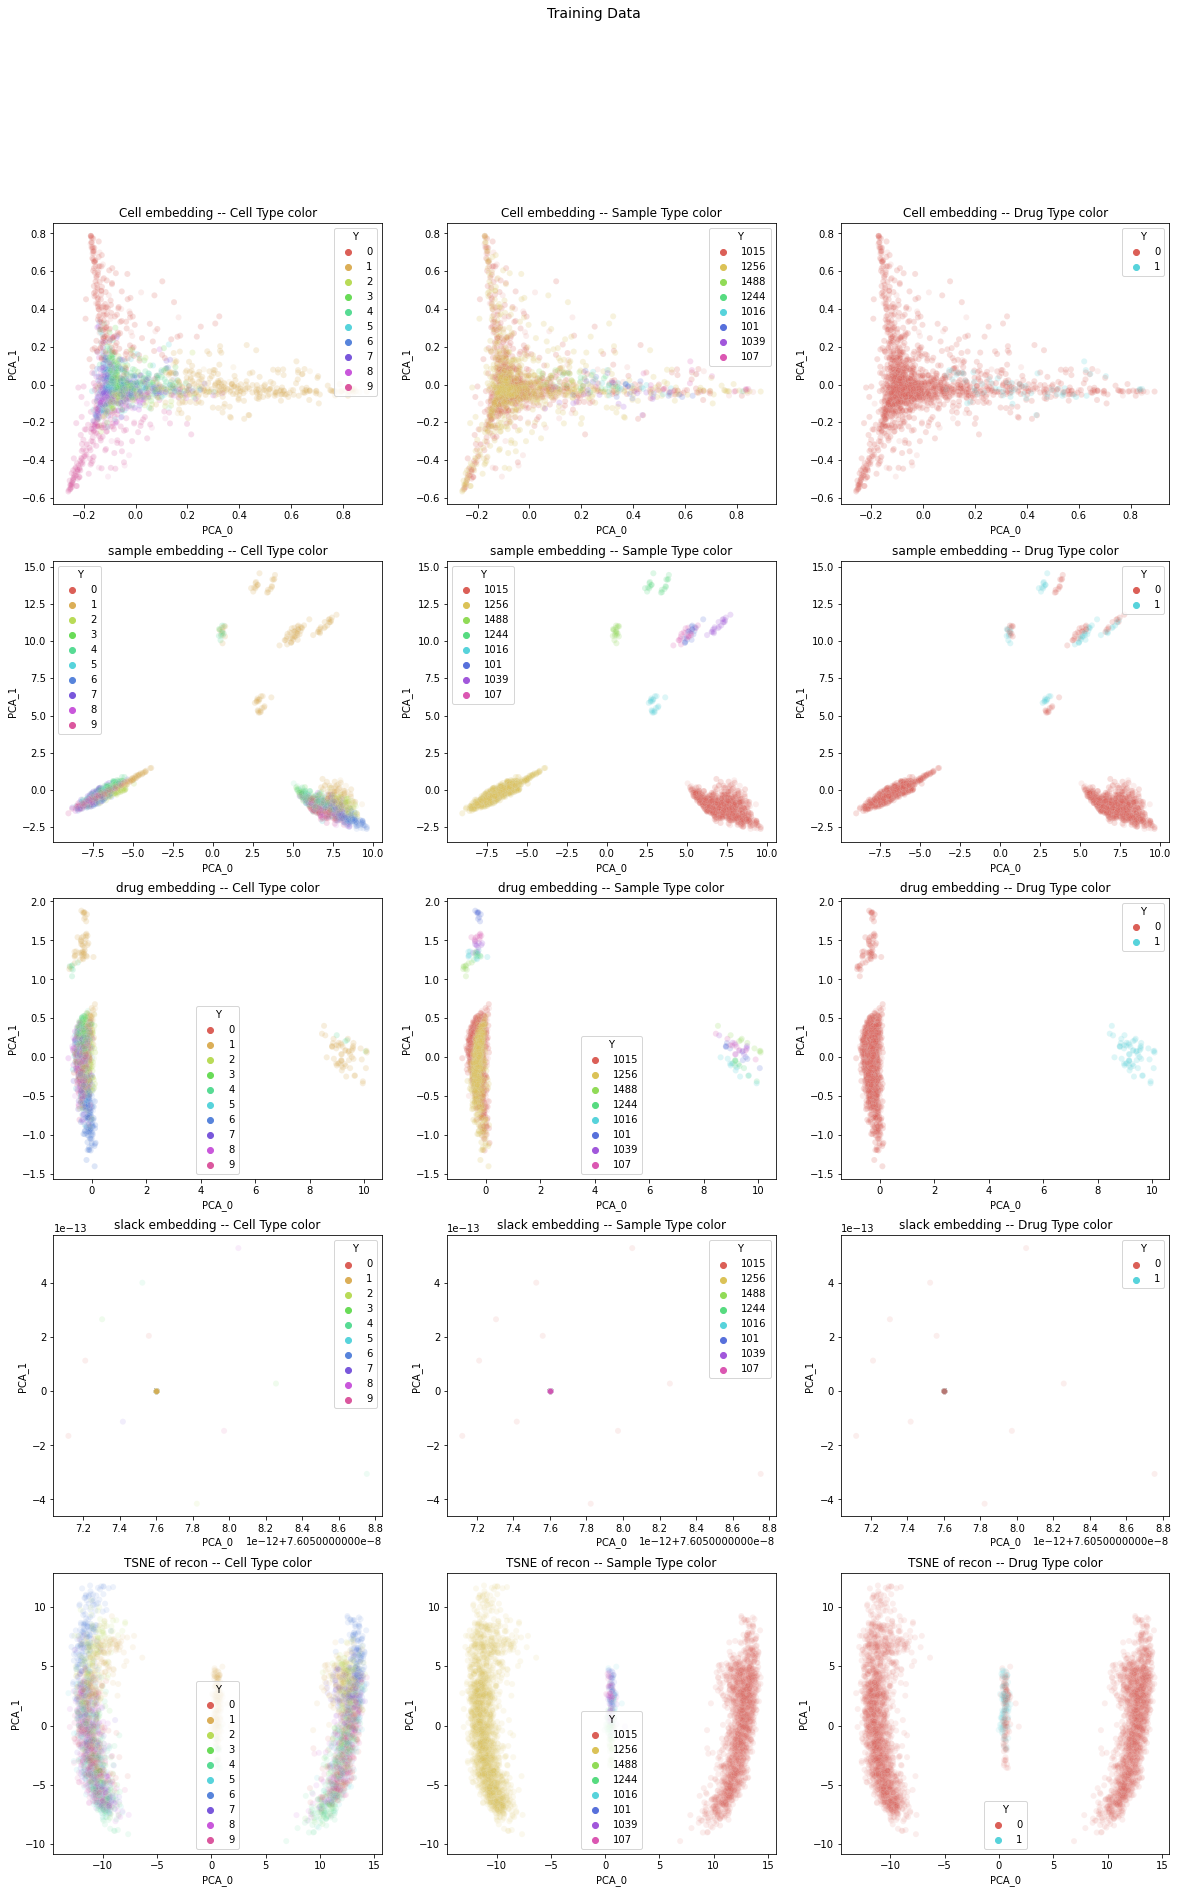

In [111]:
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data
idx_tmp = np.tile(idx_train, 2)[240:4240]

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


print(f"Number unique Y: {len(np.unique(Y_temp))}")


z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)
prop_outputs = classifier.predict(X_temp, batch_size=batch_size)


# now concatenate together
z_concat = np.hstack([z_slack, prop_outputs, z_rot, z_drug])

# and decode
decoded_outputs = decoder.predict(z_concat, batch_size=batch_size)


fig, axs = plt.subplots(5, 3, figsize=(20,30))

plot_df = vp.get_pca_for_plotting(np.asarray(prop_outputs))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[0,2], title="Cell embedding -- Drug Type color")

plot_df = vp.get_pca_for_plotting(np.asarray(mu_rot))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[1,2], title="sample embedding -- Drug Type color")

plot_df = vp.get_pca_for_plotting(np.asarray(mu_drug))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[2,0], title="drug embedding -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[2,1], title="drug embedding -- Sample Type color")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[2,2], title="drug embedding -- Drug Type color")

plot_df = vp.get_pca_for_plotting(np.asarray(mu_slack))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[3,0], title="slack embedding -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[3,1], title="slack embedding -- Sample Type color")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[3,2], title="slack embedding -- Drug Type color")

plot_df = vp.get_pca_for_plotting(np.asarray(decoded_outputs))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[4,0], title="TSNE of recon -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[4,1], title="TSNE of recon -- Sample Type color")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[4,2], title="TSNE of recon -- Drug Type color")




fig.suptitle("Training Data", fontsize=14)

fig.show()

## Do latent space projectsions

### drug perturbation

In [112]:

# run first the cell_type specific things

cell_type_specific_r2 = None
all_samps = ['101', '1016', '1039', '107', '1244', '1488']

stim_test_meta_df, ctrl_test_meta_df, decoded_1_1, decoded_0_1, decoded_0_0 = vp.calc_buddi_perturbation(meta_df, X_full, scaler, classifier, encoder_unlab, decoder, batch_size)


for curr_samp in all_samps:
    print(curr_samp)
    for curr_cell_type in Y_full.columns:
        print(curr_cell_type)

        real_stim, real_ctrl, proj_stim, proj_ctrl = vp.subset_sample_celltype_perturbation(X_full, decoded_0_0, 
                                                                                        decoded_0_1, scaler, curr_samp, 
                                                                                        "cell_type_specific", 
                                                                                        meta_df, ctrl_test_meta_df,
                                                                                        curr_cell_type)

        expr_r2, log2FC_r2 = vp.calc_expr_log2FC_r2(real_ctrl, real_stim, proj_ctrl, proj_stim)

        curr_res = [curr_samp, curr_cell_type, "cell_type_specific", expr_r2, log2FC_r2]
        curr_res = pd.DataFrame([curr_res],  columns = ['sample_id', 'cell_type', 'bulk_type', 'expr_r2', 'log2FC_r2'])

        if cell_type_specific_r2 is None:
            cell_type_specific_r2 = curr_res
        else:
             cell_type_specific_r2 = cell_type_specific_r2.append(curr_res)



# now run the realistic ones

101
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1016
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1039
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
107
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1244
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1488
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act


In [113]:
realistic_r2 = None

stim_test_meta_df, ctrl_test_meta_df, decoded_1_1, decoded_0_1, decoded_0_0 = vp.calc_buddi_perturbation(meta_df, X_full, scaler, classifier, encoder_unlab, decoder, batch_size)

for curr_samp in all_samps:

        real_stim, real_ctrl, proj_stim, proj_ctrl = vp.subset_sample_celltype_perturbation(X_full, decoded_0_0, 
                                                                                        decoded_0_1, scaler, curr_samp, 
                                                                                        "realistic", 
                                                                                        meta_df, ctrl_test_meta_df,
                                                                                        cell_type_interest=None)

        expr_r2, log2FC_r2 = vp.calc_expr_log2FC_r2(real_ctrl, real_stim, proj_ctrl, proj_stim)

        curr_res = [curr_samp, None, "realistic", expr_r2, log2FC_r2]
        curr_res = pd.DataFrame([curr_res],  columns = ['sample_id', 'cell_type', 'bulk_type', 'expr_r2', 'log2FC_r2'])

        if realistic_r2 is None:
            realistic_r2 = curr_res
        else:
             realistic_r2 = realistic_r2.append(curr_res)

In [114]:
final_r = cell_type_specific_r2.append(realistic_r2)
pearson_res_file = os.path.join(res_data_path, f"{exp_id}_pearson_matr.csv")
final_r.to_csv(pearson_res_file, index=False)


# ** THIS IS WHERE I LEFT OFF **